In [1]:
%pip install deepface mtcnn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle  # import pickle, to read and save variables
import time
from mtcnn.mtcnn import MTCNN  # MTCNN, or Multi-Task Cascaded Convolutional Neural Networks
# Scikit learn
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.utils.fixes import loguniform
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, multilabel_confusion_matrix, matthews_corrcoef
from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library
plt.rcParams["figure.figsize"] = (8, 5)
from deepface import DeepFace
from deepface.detectors import FaceDetector

<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r1, r2, r3, r4, r5</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:

0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [3]:
# Input data files are available in the read-only "../input/" directory
paths = ["/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/", "D:\Coding\Datasets\CV_GA1_data",
         "D:\computer_vision\group_assignments\data_ga1"]
# Using Kaggle -> 0, Thibeau path -> 1, Alex path -> 2
base_file_path = paths[2]

train = pd.read_csv(
    os.path.join(base_file_path, 'train_set.csv'), index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    os.path.join(base_file_path, 'test_set.csv'), index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load(os.path.join(base_file_path, 'train/train_{}.npy').format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load(os.path.join(base_file_path, 'test/test_{}.npy').format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]

train_size, test_size = len(train), len(test)
"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [4]:
# The training set contains an identifier, name, image information and class label
train.head(1)

name  class                                                img
id                                                                      
0   Mila_Kunis      2  [[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4...

In [5]:
# The test set only contains an identifier and corresponding image information.
test.head(1)

img
id                                                   
0   [[[209, 210, 205], [208, 209, 204], [208, 209,...

In [6]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

img  class
name                       
Jesse_Eisenberg   30      1
Michael_Cera      10      0
Mila_Kunis        30      2
Sarah_Hyland      10      0

Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data


<!-- <div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div> -->


Firstly, we declare a variable that will set the final size of the images for our pipeline. By default, this was (100, 100) in the template notebook, although in our case it will finally be (224, 244), which is the size used in the VGG-16 architecture that gives us the best final results. Apart from that, we also define auxiliary functions to facilitate the plotting of the images, for cutting of the images showing just the faces, or for discarding images with negative pixel values, for instance.

In [7]:
# parameter to play with 
FACE_SIZE = (224, 224)

In [8]:
def plot_image_sequence(data, n, imgs_per_row=7, cmap="Greys_r"):
    """Auxiliary function that plots a sequence of images in convenient format.
    Args:
        data (np.array): Sequence of images
        n (_type_): Number of images to plot
        imgs_per_row (int, optional): Number of images on each row. Defaults to 7.
        cmap (str, optional): Colormap used in plotting. Defaults to "Greys_r" for greyscale images.
    """
    try:
        n_rows = 1 + int(n/(imgs_per_row+1))
        n_cols = min(imgs_per_row, n)
        f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
        for i in range(n):
            if n == 1:
                ax.imshow(data[i], cmap=cmap)
            elif n_rows > 1:
                ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i], cmap=cmap)
            else:
                ax[int(i%n)].imshow(data[i], cmap=cmap)
        plt.show()
    except IndexError as e:
        print("WARN: " + str(e))

In [9]:
def cut_out_face(img, x, y, width, height, factor = 0.1, center_x = None, center_y = None, square = True):

    # If we want the images to be square, adjust height or width (go for smallest square)
    if square:
        if width <= height:
            height = width
        else:
            width = height

    # In case a central point is provided, shift the coordinates to center that object
    if center_x is not None and center_y is not None:
        x = center_x - width/2
        y = center_y - height/2

    # Get the width and height of the image
    img_height, img_width = img.shape[0], img.shape[1]

    # Get new initial positions
    new_x = max(0, int(x - factor*width))
    new_y = max(0, int(y - factor*height*2))

    new_width  = min(img_width  - new_x, int((1 + 2*factor)*width))
    new_height = min(img_height - new_y, int((1 + 2*factor)*height))

    return img[new_y:new_y+new_height, new_x:new_x+new_width]

In [10]:
def detect_negatives_images(imgs, verbose=False):
    # It detects if there are any negative pixel values
    indices_to_delete = []
    for i, img in enumerate(imgs):
        if np.any(img.flatten() < 0):
            if verbose:
                print(f"Negative values in image {i} detected")
            indices_to_delete.append(i)
    return indices_to_delete

#### 0.3.1 Data augmentation/enhancement (!)

The training data has just 80 examples, which is a quite low number. In addition to that, some pictures have multiple people in them, are a montage of different pictures of the same person or are a meme mixing real people and cartoon figures. Therefore, in this section we will do a couple of things to improve and overall quality of the training data.

We will do a quick, manual crop of some images. Sometimes, that crop will result on an easier time for the face detection algorithms, since pictures that include 2 or more people will get simplified to just show the most important one (Sarah, Jesse, Michael or Mila). At the same time, some montages or memes can include different people we are interested in, that is why we will also perform some crops so that we can divide the pictures in 2 different ones with new labels that will increase the size of the data.

In [11]:
train_improved = train.copy()
print("Length of TRAIN df: " + str(len(train_improved.index)))

Length of TRAIN df: 80


**INDEX 18:**

***Before:*** The picture shows both Jesse and Michael, but it is classified just as Jesse (label=1).

***After:*** Image at Index 18 just show Jesse now, and new image at Index 80 is created with the other side of the original picture and labeled as Michael (label=0)

In [12]:
aux = pd.DataFrame({"name": ["Michael_Cera"], "class": [0], "img": [train_improved.loc[18].img[:, 270:]]})
train_improved = train_improved.append(aux, ignore_index=True)
train_improved["img"][18] = train_improved.loc[18].img[:, :260]

**INDEX 25:**

***Before:*** The picture shows both Michael and a cartoon.

***After:*** Image cropped to just show Michael.

In [13]:
train_improved["img"][25] = train_improved.loc[25].img[:, 200:]

**INDEX 28:**

***Before:*** The picture shows Mila with 2 other people.

***After:*** Image cropped to just show Mila.

In [14]:
train_improved["img"][28] = train_improved.loc[28].img[:, 275:625]

**INDEX 29:**

***Before:*** The picture shows Mila with another person.

***After:*** Image cropped to just show Mila.

In [15]:
train_improved["img"][29] = train_improved.loc[29].img[:, :400]

**INDEX 30:**

***Before:*** The picture shows two pictures of Mila.

***After:*** Image separated to get two samples from it (Indexes 30 & 81).

In [16]:
aux = pd.DataFrame({"name": ["Mila_Kunis"], "class": [2], "img": [train_improved.loc[30].img[:, :100]]})
train_improved = train_improved.append(aux, ignore_index=True)
train_improved["img"][30] = train_improved.loc[30].img[:, 100:]

**INDEX 32:**

***Before:*** The picture shows two pictures of Sarah.

***After:*** Image separated to get two samples from it (Indexes 32 & 82).

In [17]:
aux = pd.DataFrame({"name": ["Sarah_Hyland"], "class": [0], "img": [train_improved.loc[32].img[:, 420:]]})
train_improved = train_improved.append(aux, ignore_index=True)
train_improved["img"][32] = train_improved.loc[32].img[:, :420]

**INDEX 34:**

***Before:*** The picture shows Michael, Jesse and a third person in a Pokémon meme.

***After:*** Image cropped to get Jesse at Index 34 and Michael at new Index 83.

In [18]:
aux = pd.DataFrame({"name": ["Michael_Cera"], "class": [0], "img": [train_improved.loc[34].img[160:, :160]]})
train_improved = train_improved.append(aux, ignore_index=True)
train_improved["img"][34] = train_improved.loc[34].img[160:, 210:380]

**INDEX 39:**

***Before:*** The picture shows Mila with another person.

***After:*** Image cropped to just get Mila.

In [19]:
train_improved["img"][39] = train_improved.loc[39].img[:, 125:220]

**INDEX 40:**

***Before:*** The picture shows Mila with another person.

***After:*** Image cropped to just get Mila.

In [20]:
train_improved["img"][40] = train_improved.loc[40].img[:, 107:]

**INDEX 41:**

***Before:*** The picture shows Michael with another person.

***After:*** Image cropped to just get him.

In [21]:
train_improved["img"][41] = train_improved.loc[41].img[:, :200]

**INDEX 49:**

***Before:*** The picture shows Jesse with another person.

***After:*** Image cropped to just get him.

In [22]:
train_improved["img"][49] = train_improved.loc[49].img[:, :150]

**INDEX 50:**

***Before:*** The picture shows Mila with another person.

***After:*** Image cropped to just get her.

In [23]:
train_improved["img"][50] = train_improved.loc[50].img[:200, :]

**INDEX 52:**

***Before:*** The picture shows Jesse with another person.

***After:*** Image cropped to just get him.

In [24]:
train_improved["img"][52] = train_improved.loc[52].img[:, 325:]

**INDEX 53:**

***Before:*** The picture shows Jesse with another person.

***After:*** Image cropped to just get him.

In [25]:
train_improved["img"][53] = train_improved.loc[53].img[:, 300:]

**INDEX 57:**

***Before:*** The picture shows 2 photos of Mila (with sunglasses).

***After:*** Image cropped to get one at Index 57 and the other at new Index 84.

In [26]:
aux = pd.DataFrame({"name": ["Mila_Kunis"], "class": [2], "img": [train_improved.loc[57].img[:, :100]]})
train_improved = train_improved.append(aux, ignore_index=True)
train_improved["img"][57] = train_improved.loc[57].img[:, 100:]

**INDEX 59:**

***Before:*** The picture shows a photo of Sarah with another person.

***After:*** Image cropped to just get her.

In [27]:
train_improved["img"][59] = train_improved.loc[59].img[:, 220:]

**INDEX 61:**

***Before:*** The picture shows a photo of Mila with another person.

***After:*** Image cropped to just get her.

In [28]:
train_improved["img"][61] = train_improved.loc[61].img[:, 200:]

**INDEX 70:**

***Before:*** The picture shows a photo of Jesse with 2 other people.

***After:*** Image cropped to just get him.

In [29]:
train_improved["img"][70] = train_improved.loc[70].img[:, 175:]

**INDEX 77:**

***Before:*** The picture shows 2 photos of Mila.

***After:*** Image cropped to get one at Index 77 and the other at new Index 85.

In [30]:
aux = pd.DataFrame({"name": ["Mila_Kunis"], "class": [2], "img": [train_improved.loc[77].img[:, :100]]})
train_improved = train_improved.append(aux, ignore_index=True)
train_improved["img"][77] = train_improved.loc[77].img[:, 100:]

In [31]:
print("New length of TRAIN df: " + str(len(train_improved.index)))

New length of TRAIN df: 86


##### 0.3.1.1 Previous data enhancement

This subsection shows the steps performed in the basic data enhancement initially used for the rest of the global process. In this case, before the face detection and preprocessings, there is just one crop of a training image, since it was causing issues with one of the face detection algorithms used below.

In [32]:
img = train.loc[40].img
crop_width = 100
cropped_img = img[:, crop_width:]
train["img"][40] = cropped_img

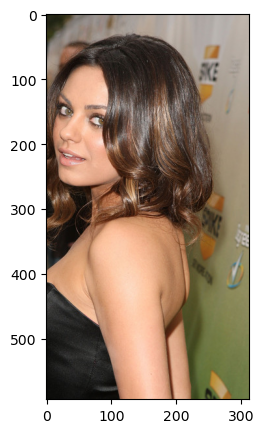

In [33]:
img = train.loc[40].img
plt.imshow(img)

### 0.3.2 HAAR preprocessor

The first preprocessor we try out is the HaarPreprocessor. In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one.

About this cascade classifiers it can be said that they are part of a machine learning approach where a lot of images with faces and others with any are needed to train the model. The extraction of the features of the images using white/black rectangles is quite inefficient, so Adaboost is used to select the best features, and for each feature, the best threshold is found. In the end, at the time of its implementation, a pretrained model is used from a XML file and the detection is mainly done with the method detectMultiScale.

In [34]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        # original HAAR img size
        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
        #return [cut_out_face(img, x, y, w, h) for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

This HAAR preprocessor is now just used for the train data to show visualization examples in the following subsection and how the process of discarding bad images would look like, since better results can be achieved with different preprocessing techniques.

Either way, firstly the HAAR preprocessor object has to be created for its later use on the train data:

In [35]:
haar_preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)

train_X_HAAR, train_y_HAAR = haar_preprocessor(train), train['class'].values

##### 0.3.2.1 Visualization

Visualization of the results of the HAAR preprocessor on the basic train data:

In [ ]:
plot_image_sequence(train_X_HAAR, n=len(train_X_HAAR), imgs_per_row=10)

Remove images that had any negative pixel value, since it would mean that there was no detection:

In [ ]:
# Get the indices of the images with no detection
indices_to_delete = detect_negatives_images(train_X_HAAR, True)

# Update both the train_X and train_Y arrays deleting those unuseful examples
train_X_HAAR = np.delete(train_X_HAAR, indices_to_delete, axis=0)
train_y_HAAR = np.delete(train_y_HAAR, indices_to_delete, axis=0)
plot_image_sequence(train_X_HAAR, n=len(train_X_HAAR), imgs_per_row=10)

Remove some manually detected false positives and show how the final images would look like:

In [ ]:
# Try to remove images that aren't faces or aren't Mila, Jesse, Michael, or Sarah
indices_not_faces = [5, 17, 22, 23, 27, 33, 38, 47, 58, 59, 62, 67]
train_X_HAAR = np.delete(train_X_HAAR, indices_not_faces, axis=0)
train_y_HAAR = np.delete(train_y_HAAR, indices_not_faces, axis=0)
plot_image_sequence(train_X_HAAR, n=len(train_X_HAAR), imgs_per_row=10)

Finally, we could also look at the different people by their labels. For instance, we will show the images of Mila:

In [ ]:
plot_image_sequence(train_X_HAAR[train_y_HAAR == 2], n=len(train_X_HAAR[train_y_HAAR == 2]), imgs_per_row=10)

### 0.3.3 MTCNN preprocessor (!)

The HAAR preprocessing gives a limited performance when it comes to face detection. Therefore, other possibilities have been explored, and the first of them is a MTCNN preprocessor. MTCNN stands for MultiTask Cascaded Convolutional Networks, which is a deep learning approach that adopts a cascaded structure of 3 stages which exploits the correlation between face detection and alignment in unconstrained environments to move past the performance of other methods like the previous one.

In this section, we look at this [paper](https://arxiv.org/abs/1604.02878) and this [article](https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/) for the implementation of the framework. The *mtcnn* package needs to be installed initially, and from that, the pipeline is built is a similar fashion to the other one.

In [40]:
class MTCNNPreprocessor():
    """Preprocessing pipeline built around MTCNN."""
    
    def __init__(self, face_size, bbox_factor = 0.2):

        self.face_size = face_size
        self.detector = MTCNN()
        self.bbox_factor = bbox_factor

    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        # Make a copy, since MTCNN plots bounding boxes on top of our images
        return self.detector.detect_faces(img.copy())
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        # Detect the faces
        faces = self.detect_faces(img)
        # Boxes contain x, y, w, h of bounding box of each detected face
        boxes    = [face['box'] for face in faces]  
        # Nose key gives x and y
        noses = [face['keypoints']['nose'] for face in faces]
        
        # Extract faces
        extracted_faces = []
        for i in range(len(faces)):
            x, y, w, h = boxes[i]
            center_x, center_y = noses[i]
            cut_out = cut_out_face(img, x, y, w, h, factor = self.bbox_factor, center_x = center_x, center_y = center_y)
            extracted_faces.append(cut_out)
        
        return extracted_faces
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face, and resize
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

In the same way as in the previous case, this MTCNN preprocessor is now just used for the train data to show visualization examples in the following subsection and how the process of discarding bad images would look like, since better results can still be achieved with the last preprocessing technique shown in this notebook. Also, by doing so, the differences between this first two approaches can be seen in the final pictures.

The first step, as always, is defining the instance of the MTCNN preprocessor object, to use right after on the train data:

In [ ]:
mtcnn_preprocessor = MTCNNPreprocessor(FACE_SIZE)

train_X_MTCNN, train_y_MTCNN = mtcnn_preprocessor(train), train['class'].values

##### 0.3.3.1 Visualization

Visualization of the initial results of the MTCNN preprocessor on the basic train data:

In [ ]:
plot_image_sequence(train_X_MTCNN, n=len(train_X_MTCNN), imgs_per_row=10)

And now, in the same way it was done in the HAAR case, the non-detections and some bad results are discarded to get a final cleaned set of images:

In [ ]:
# Remove some manually detected bad results
indices_not_faces = [8, 28, 30, 40]
train_X_MTCNN = np.delete(train_X_MTCNN, indices_not_faces, axis=0)
train_y_MTCNN = np.delete(train_y_MTCNN, indices_not_faces, axis=0)

# Discard non-detections
indices_to_delete = detect_negatives_images(train_X_MTCNN, True)

# Update both the train_X and train_Y arrays deleting those indices
train_X_MTCNN = np.delete(train_X_MTCNN, indices_to_delete, axis=0)
train_y_MTCNN = np.delete(train_y_MTCNN, indices_to_delete, axis=0)
plot_image_sequence(train_X_MTCNN, n=len(train_X_MTCNN), imgs_per_row=10)

### 0.3.4 DeepFace preprocessor

To explain how the DeepFace preprocessor works, let's look at an example. Both HAAR and MTCNN failed on training image with index 49, shown below. The detectors have a more confidence detection due to Kristen Stewart. We can exploit the knowledge from the class label, and use a template of Jesse to force our detector to detect Jesse's face instead by relying on a similarity score.

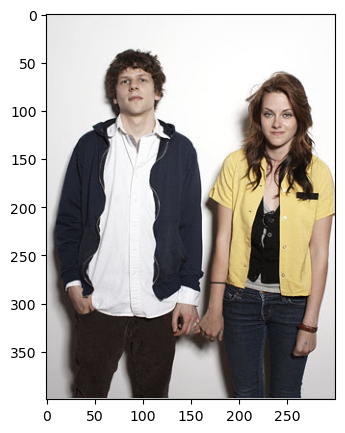

In [311]:
test_image = train.loc[49].img
plt.imshow(test_image)

We saved a template where Jesse's face is clearly visible and the single face in the picture. We load it in:

In [312]:
template_jesse = cv2.imread("template_jesse.png")
template_jesse = template_jesse[...,::-1]

We then use DeepFace's "verify" method, which compares two images and verifies that the same person is present in both images. In the example output, we see that DeepFace then gives us two facial areas: one for each image. Since we are not interested in the template, we take the face from the first iamge.

In [313]:
result = DeepFace.verify(img1_path = test_image, img2_path = template_jesse)

In [314]:
### Example output:
# {'verified': True,
#  'distance': 0.11051846168495327,
#  'threshold': 0.4,
#  'model': 'VGG-Face',
#  'detector_backend': 'opencv',
#  'similarity_metric': 'cosine',
#  'facial_areas': {'img1': {'x': 65, 'y': 49, 'w': 54, 'h': 54},
#   'img2': {'x': 116, 'y': 83, 'w': 124, 'h': 124}},
#  'time': 2.23
# }

The detected face, when cropped out and plotted  below, is indeed Jesse's face -- we hence were able to detect the desired face in this image due to DeepFace!

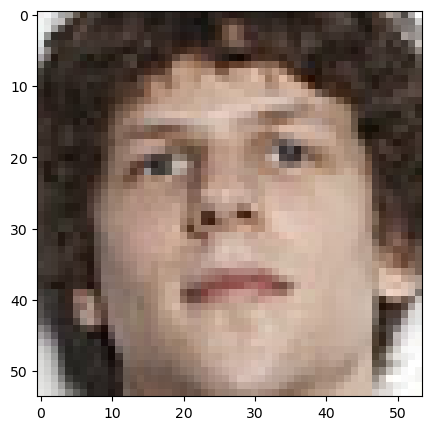

In [315]:
face = result["facial_areas"]["img1"]
x, y, w, h = face["x"], face["y"], face["w"], face["h"]
# Plot the face
plt.imshow(test_image[y:y+h, x:x+w])
plt.show()

In case we cannot use the template (it is not Jesse or Mila), we have to resort back to a simple face detector to detect faces. Here is an example

In [316]:
detector = FaceDetector.build_model("opencv") #set opencv, ssd, dlib, mtcnn or retinaface
obj = FaceDetector.detect_faces(detector, "opencv", test_image)
obj

[(array([[[147, 126, 109],
          [172, 151, 134],
          [127, 101,  84],
          ...,
          [ 55,  37,  25],
          [ 65,  47,  37],
          [ 66,  50,  37]],
  
         [[174, 153, 136],
          [147, 126, 109],
          [103,  80,  64],
          ...,
          [ 62,  44,  32],
          [ 65,  45,  36],
          [ 59,  45,  34]],
  
         [[179, 160, 145],
          [115,  96,  79],
          [ 96,  73,  57],
          ...,
          [ 63,  45,  33],
          [ 79,  59,  50],
          [ 64,  50,  39]],
  
         ...,
  
         [[ 89,  69,  60],
          [ 95,  66,  58],
          [ 79,  52,  43],
          ...,
          [102,  71,  53],
          [ 54,  33,  28],
          [ 46,  23,  15]],
  
         [[ 74,  57,  49],
          [ 95,  68,  59],
          [ 66,  42,  32],
          ...,
          [ 97,  64,  47],
          [ 44,  24,  23],
          [ 37,  17,  10]],
  
         [[ 80,  66,  57],
          [ 78,  51,  42],
          [ 64,  40,  30

The output is a bit weird, but (as far as I understand) it is a list containing the original image, the bounding box of the face, and some score of the detection. Getting the face out of the image is done as follows (note that the opencv detector again detects Kristen Stewart)

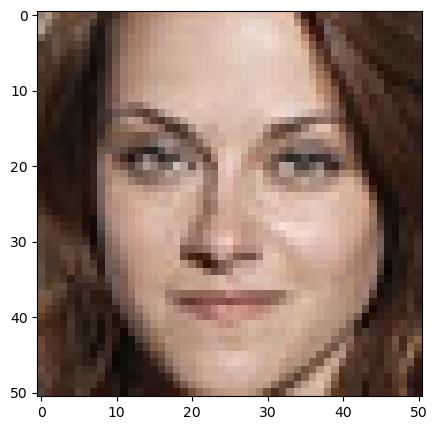

In [317]:
x, y, w, h = obj[0][1]
# Plot the face
plt.imshow(test_image[y:y+h, x:x+w])
plt.show()

`DEEPPreprocessor` is a preprocessor based on [DeepFace](https://github.com/serengil/deepface). 

In [318]:
class DEEPPreprocessor():
    
    def __init__(self, face_size, template_jesse_loc ="template_jesse.png", template_mila_loc = "template_mila.png",
                 detector_name = "opencv"):
        """Preprocessing pipeline built around DeepFace. 

        Args:
            face_size (tuple[int, int]): Size of the faces for resizing after successful face detection.
            template_jesse_loc (str, optional): Filename of template image of Jesse. Defaults to "template_jesse.png".
            template_mila_loc (str, optional): Filename of template image of Mila. Defaults to "template_mila.png".
            detector_name (str, optional): Argument required by DeepFace's FaceDetector object. Possible choices are
            opencv, ssd, dlib, mtcnn or retinaface. NOTE - retinaface gave some error! Defaults to "opencv".
        """
        
        # Save face size
        self.face_size = face_size
        
        # Load in Jesse's template
        self.template_jesse = cv2.imread(template_jesse_loc)
        self.template_jesse = self.template_jesse[...,::-1]
        
        # Load in Mila's template
        self.template_mila = cv2.imread(template_mila_loc)
        self.template_mila = self.template_mila[...,::-1]
        
        # Initialize face detector
        self.detector_name = detector_name
        self.detector = FaceDetector.build_model(self.detector_name) 
        
            
    def extract_face(self, img, label):
        """Detect and cut out face out of the image. NOTE - unlike HAAR and MTCNN, DeepFace methods detects a single face.
        This method decides how to detect faces based on the label that is provided, and hence can only be used on training data
        to improve the face detection and extraction. If the label is 1 or 2, we rely on the templates of Jesse and Mila to 
        improve the performance of the detector (cf. Kristen Stewart example).

        Args:
            img (np.array): Image.
            label (int): Class label of training data.

        Returns:
            np.array: Face cropped out of the image.
        """
        
        # Initialize the face bounding box to an empty box (in case no detection, still empty box)
        x, y, w, h = 0, 0, 0, 0
        # In case we do NOT have Jesse or Mila, just use face detector
        if label == 0:
            # Detect a face
            face = FaceDetector.detect_faces(detector, self.detector_name, img)
            # Get the bounding box
            x, y, w, h = face[0][1]
        else:
            # In case we know we have to detect Jesse or Mila, make sure we detect them! Use "verify"
            if label == 1:
                template = self.template_jesse
            elif label == 2:
                template = self.template_mila
            # Use template to verify faces
            result = DeepFace.verify(img1_path = img, img2_path = template, enforce_detection=False)
            face = result["facial_areas"]["img1"]
            x, y, w, h = face["x"], face["y"], face["w"], face["h"]
            
        return img[y:y+h, x:x+w]
    
    def preprocess(self, data_row):
        """Preprocesses the data and extracts the images out of it.

        Args:
            data_row (pd.DataFrame): Pandas dataframe of training data (images and class labels).

        Returns:
            _type_: _description_
        """
        
        # Detect face
        face = self.extract_face(data_row['img'], data_row['class'])
        
        # No face detected, return nan image                
        if len(face.flatten()) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # Resize if face detected
        return cv2.resize(face, self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

Use it to preprocess training data

In [319]:
deep_preprocessor = DEEPPreprocessor(FACE_SIZE)
train_X_DEEP, train_y_DEEP = deep_preprocessor(train), train['class'].values

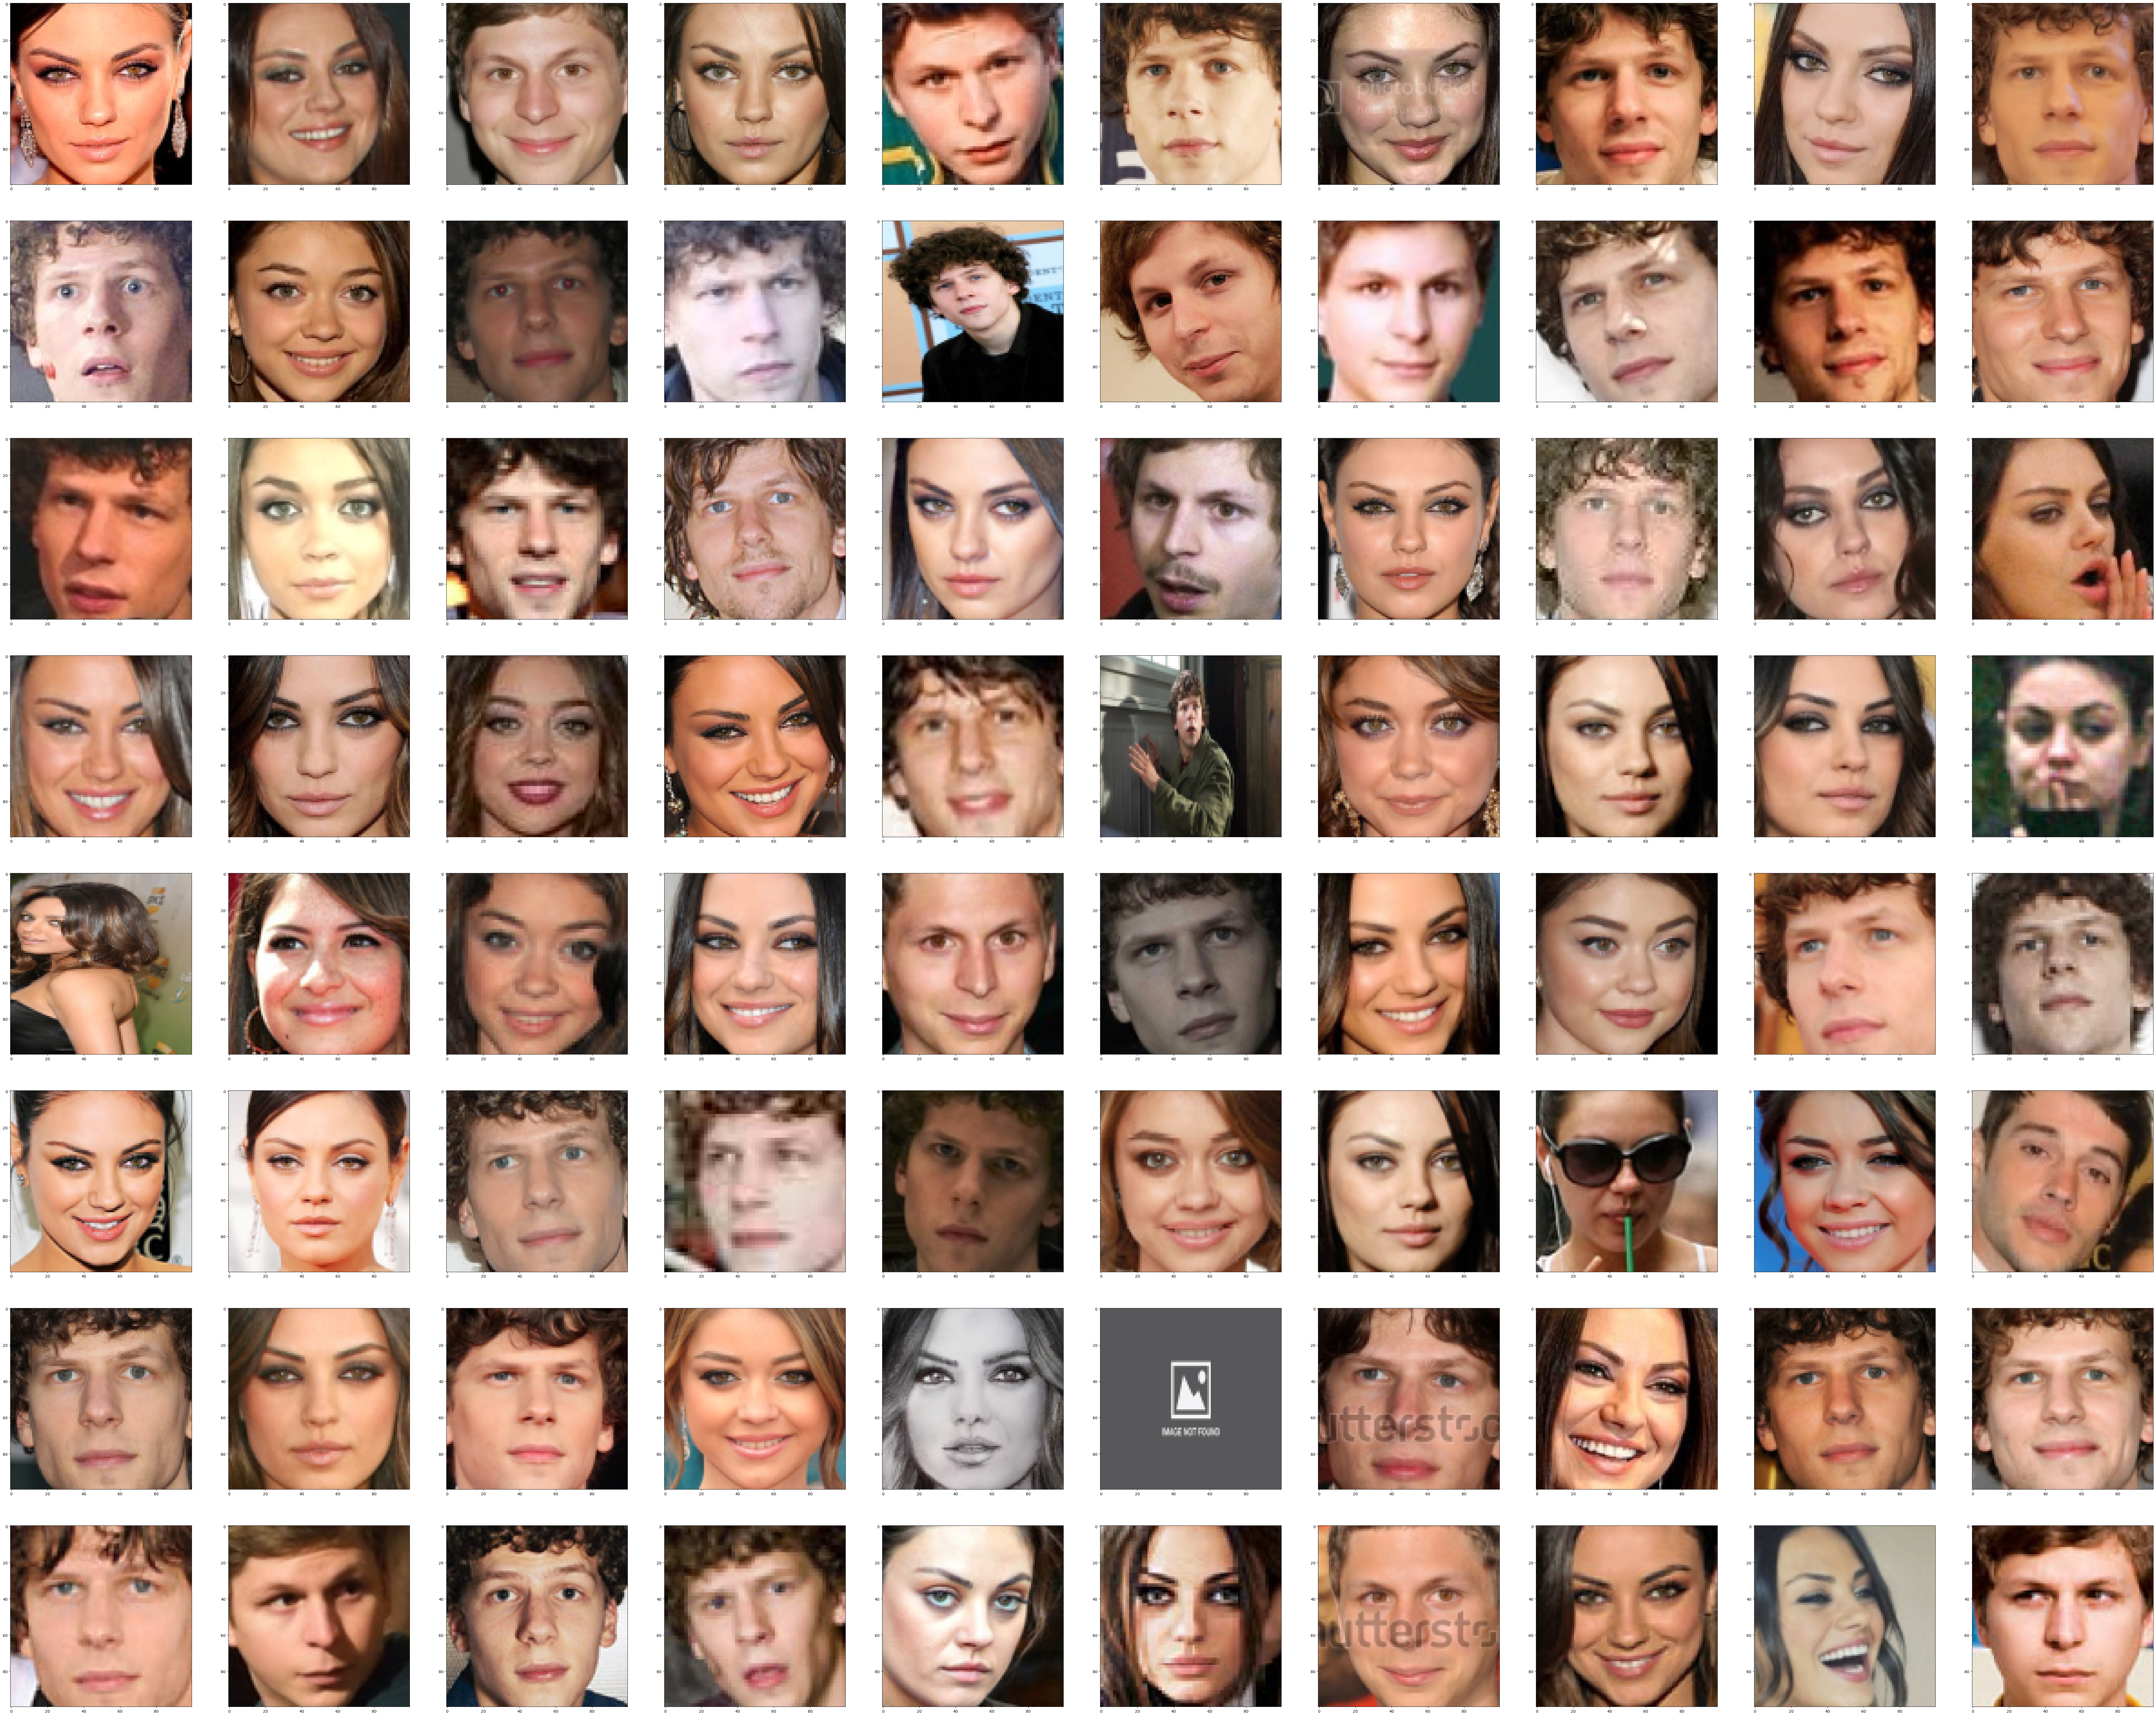

In [320]:
img_seq = train_X_DEEP
plot_image_sequence(img_seq, n=len(img_seq), imgs_per_row=10)

We delete a few bad faces:

In [321]:
# Remove images that aren't faces or aren't mila, jesse, michael, or sarah
indices_not_faces = [14, 35, 39, 40, 57, 65]
train_X_DEEP = np.delete(train_X_DEEP, indices_not_faces, axis=0)
train_y_DEEP = np.delete(train_y_DEEP, indices_not_faces, axis=0)

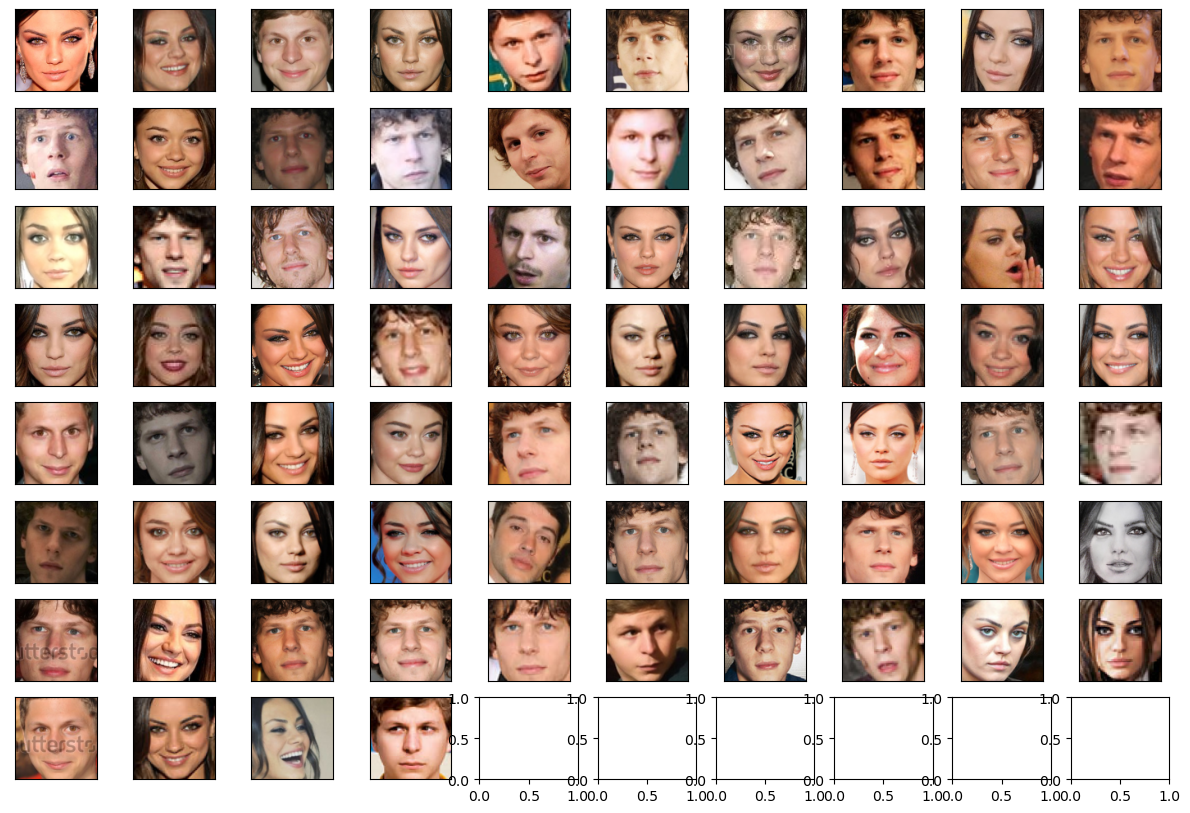

In [322]:
img_seq = train_X_DEEP
fig, axs = plt.subplots(8, 10, figsize = (15, 10))
for i, img in enumerate(img_seq):
    ax = axs[i//10, i%10]
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

### 0.3.5 Choose data to work with

In [323]:
train_X = train_X_DEEP
train_y = train_y_DEEP

## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [324]:
# save preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
    
# np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
# np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
# np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

# load preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
# train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
# train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
# test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

# 1. Feature Representations
Feature extractors will be subclasses of a simple base class that implements the identity function:
$$
\forall x : f(x) = x.
$$


In [325]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: Scale Invariant Feature Transform (SIFT)

SIFT is a method of feature extraction that is invariant to various transformations, such as scale, orientation, angle, etc. This makes it a promising method for face recognition as it can extract facial features specific to a person of interest from various images. A successful SIFT implementation is robust (same features are extracted from the same object in different conditions) and discriminative (different image objects can be easily separated from each other in feature space).

In this section we will implement SIFT using the opencv framework and demonstrate the advantages and disadvantages of these handcrafted features.

In [326]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import time
from sklearn.utils.fixes import loguniform


class SIFTFeatureExtractor(IdentityFeatureExtractor):

    # initialize feature extractor
    def __init__(self, nFeatures, sigma, nOctaveLayers = 3, contrastThreshold = .04, edgeThreshold=10):
        self.nFeatures = nFeatures
        self.sigma = sigma
        self.allDescriptors = None
        self.allKeypoints = None
        self.sift = cv2.SIFT_create(nfeatures=nFeatures, sigma=sigma, nOctaveLayers=nOctaveLayers, contrastThreshold=contrastThreshold, edgeThreshold=edgeThreshold)

    # get keypoints and feature descriptors for each image
    def detect_and_compute(self, images):
        all_descriptors = np.zeros((len(images),self.nFeatures, 128))
        all_keypoints = []
        # iterate over all images
        for i in range(len(images)):
            #normalize contrast
            im = np.array(images[i], dtype='uint8')
            # convert to grayscale
            gray= cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
            # apply bilateral filter to reduce noise
            filtered = cv2.bilateralFilter(gray, 3,150,150)
            # detectAndCompute returns keypoints and feature descriptors
            kp1, des1 = self.sift.detectAndCompute(filtered, None)
            (rows,columns) = des1.shape
            # maintain only nFeatures features for each image
            if rows>self.nFeatures:
                des1 = des1[0:self.nFeatures]
            all_descriptors[i] =np.array(des1)
            all_keypoints.append(np.array(kp1)[0:self.nFeatures])
        self.allKeypoints = all_keypoints
        self.allDescriptors = all_descriptors
        return all_descriptors, all_keypoints

    # return all matching features between two images
    def match(self, des1, des2):
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50) # or pass empty dictionary
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(np.float32(des1), np.float32(des2), k=2)
        return matches

    # draw the keypoints of an image
    def drawKeypoints(self, img, keypoints):
        image = np.zeros((100,100,3))
        image =cv2.drawKeypoints(img,keypoints,image)
        plt.imshow(image)

    # draw the matches between two images
    def drawMatches(self, im1, kp1, des1, im2, kp2, des2):
        matches = self.match(des1, des2)
        ratio_thresh = .85
        good_matches = []
        for m,n in matches:
            if m.distance < ratio_thresh * n.distance:
                good_matches.append([m])
        im = cv2.drawMatchesKnn(im1, kp1, im2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        fig=plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        ax.imshow(im)
        plt.show()

    # filter out the poor matches between two images
    def getGoodFeatures(self, class_template, desc, kp):
        good_descriptors = []
        good_keypoints = []
        for i,des in enumerate(desc):
            matches = SIFTExtractor.match(class_template, des)
            # measure euclidian distance between two matches
            ratio_thresh = .85
            for m,n in matches:
                if m.distance < ratio_thresh * n.distance:
                    good_descriptors.append(des[m.queryIdx])
                    good_keypoints.append(kp[i][m.queryIdx])
        return good_descriptors, good_keypoints

### 1.1.1. Extracting Features
First we initialize our SIFT extractor with the parameters nFeatures=10 and sigma=.6.

Selecting a value of 10 for nFeatures allows our SIFT extractor to limit keypoints to discriminative features such as the contours of the eyes, nose, mouth.

The sigma parameter represents the sigma of the Gaussian that is applied to the image. Since our images have a weak quality and an additional bilateral filter is applied to each image before extracting features, we reduce this number.

These values (as well as the optional parameters contrastTreshold, edgeThreshold, nOctaveLayers) can be customized for various recognition tasks and depending on the quality of the input images.

In [327]:
SIFTExtractor = SIFTFeatureExtractor(nFeatures=10, sigma=.6, nOctaveLayers = 3, contrastThreshold = .04, edgeThreshold=10)

As an example, the descriptors and keypoints are extracted from four images. The matches between these four images will be visualized in the following cells.

In [328]:
# get keypoint and feature descriptors from each class of data
descriptors_mila, keypoints_mila = SIFTExtractor.detect_and_compute(train_X[train_y==2])
descriptors_jesse, keypoints_jesse = SIFTExtractor.detect_and_compute(train_X[train_y==1])
descriptors_michael_and_sarah, keypoints_michael_and_sarah = SIFTExtractor.detect_and_compute(train_X[train_y==0])

gray_jesse_1   = cv2.cvtColor(np.uint8(train_X[train_y==1][0]),cv2.COLOR_BGR2GRAY)
gray_jesse_2   = cv2.cvtColor(np.uint8(train_X[train_y==1][1]),cv2.COLOR_BGR2GRAY)
gray_michael_1 = cv2.cvtColor(np.uint8(train_X[train_y==0][0]),cv2.COLOR_BGR2GRAY)
gray_mila_1    = cv2.cvtColor(np.uint8(train_X[train_y==2][0]),cv2.COLOR_BGR2GRAY)

Here we visualize the keypoints on an image of Jesse Eisenberg. Notably, we can see some distinct features extracted from the eyes, nostrils, and mouth edges.

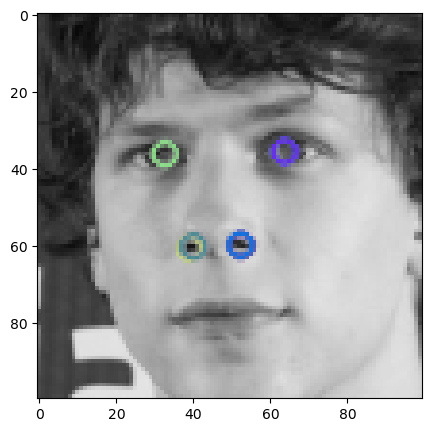

In [329]:
SIFTExtractor.drawKeypoints(gray_jesse_1, keypoints_jesse[0])

Let's visualize the features of two different images of Jesse Eisenberg. We see that the eye and nostril feature descriptors are robust as our SIFT extractor identifies them as matching features in both image representations. We do however see a false match between Jesse's mouth and nostril. This might be a result of the different lighting in each image. Normalizing the contrast in each image could help discriminate these features.

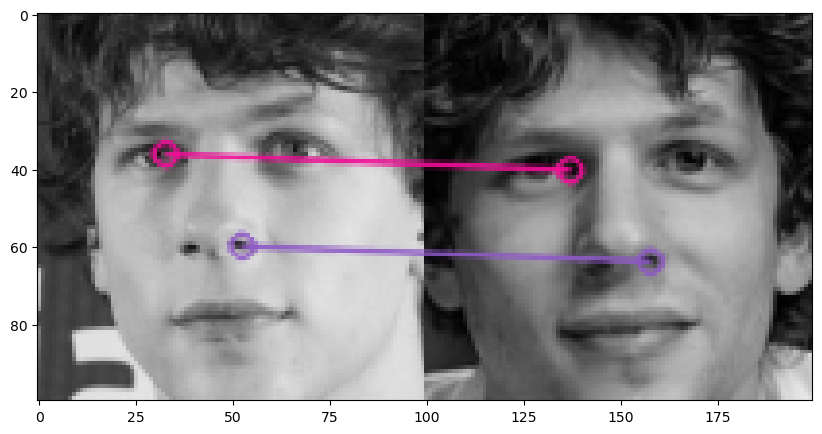

In [330]:
SIFTExtractor.drawMatches(gray_jesse_1, keypoints_jesse[0], descriptors_jesse[0], gray_jesse_2, keypoints_jesse[1], descriptors_jesse[1])

Now we visualize the features of Jesse Eisenberg and Mila Kunis. We see that no features are identified as matching between these two images. This suggests that the feature representations are discriminative as they are distinguishable between two different people.

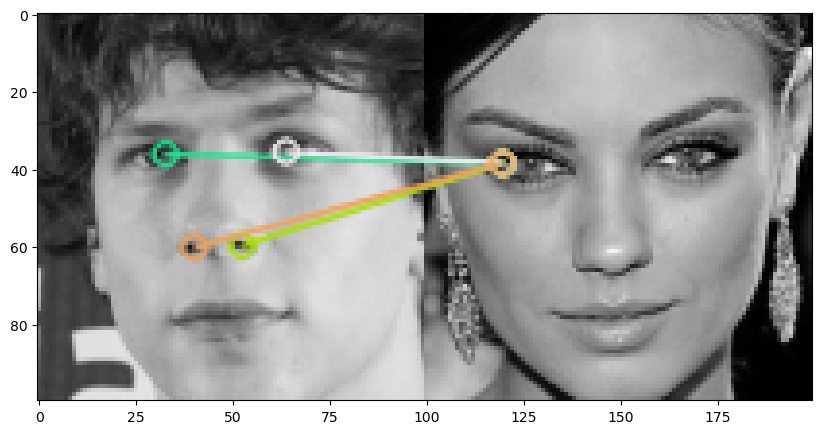

In [331]:
SIFTExtractor.drawMatches(gray_jesse_1, keypoints_jesse[0], descriptors_jesse[0], gray_mila_1, keypoints_mila[0], descriptors_mila[0])

A true test of our feature recognition system is comparing the features of two 'lookalikes'. For this we visualize the features of Jesse Eisenberg and Michael Cera. The SIFT extractor falsely finds a match between the eye feature representation of these two images. This suggests that the feature descriptors are not local enough.

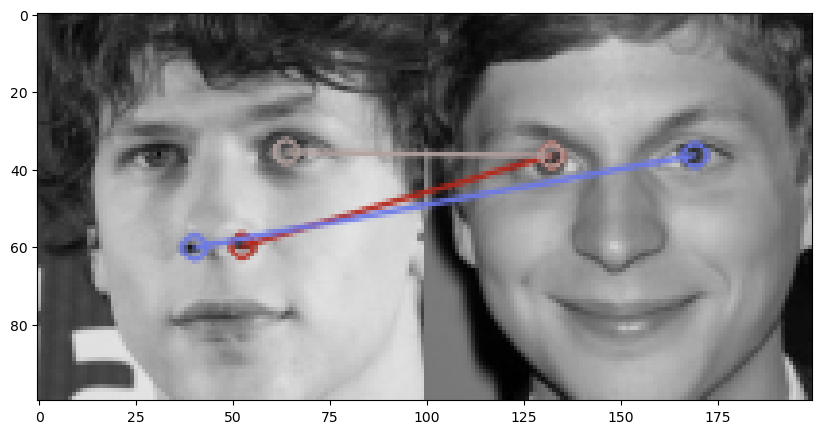

In [332]:
SIFTExtractor.drawMatches(gray_jesse_1, keypoints_jesse[0], descriptors_jesse[0], gray_michael_1, keypoints_michael_and_sarah[0], descriptors_michael_and_sarah[0])

### 1.1.2. T-SNE Plot
T-SNE or t-Distributed Stochastic Neighbor Embedding is a method of visualizing high dimensional data in fewer dimensions.

Here we visualize the good descriptors of Jesse Eisenberg and Mila Kunis. A descriptor is deemed good if it is similar to other descriptors in the same locality of the image. Similarity here is measured with euclidean distance.

In this section we will use the t-SNE framework from sklearn. We first initialize a TSNE object with the parameters n_components=2, perplexity=20, early_exaggeration=20 and the optional parameters learning_rate='auto', init='random', n_iter=2000.

We choose 2 for the number of components because it more intuitive for visualization purposes. Perplexity is generally a value between 5 and 50 that represents the balance between local and global features in our feature space. We choose 50 for this value as we estimate 50 near neighbors in each class. A value of 20 is chosen for early_exaggeration to accentuate the distance between classes.

We can see that the features for Jesse and Mila form two distinct classes. However, the distance between these two classes is not very big. This is expected as the feature representations for facial features may be similar even from person to person.

[t-SNE] Computing 52 nearest neighbors...
[t-SNE] Indexed 53 samples in 0.003s...
[t-SNE] Computed neighbors for 53 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 53 / 53
[t-SNE] Mean sigma: 475.663559
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.386391
[t-SNE] KL divergence after 700 iterations: 0.021034
[t-SNE] Computing 79 nearest neighbors...
[t-SNE] Indexed 80 samples in 0.000s...
[t-SNE] Computed neighbors for 80 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 80 / 80
[t-SNE] Mean sigma: 266.433954
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.314926
[t-SNE] KL divergence after 750 iterations: 0.207079


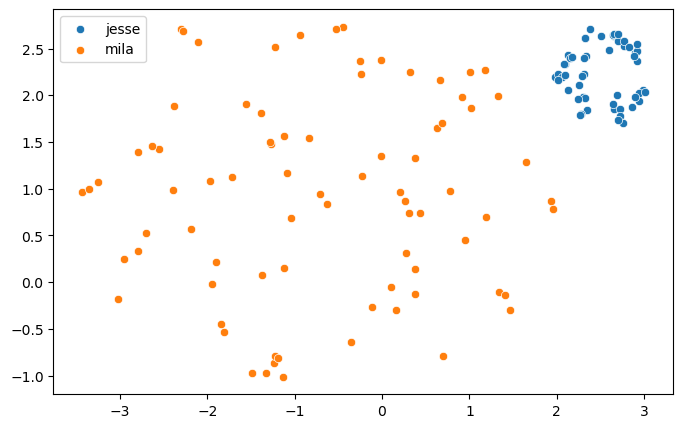

In [333]:
from sklearn.manifold import TSNE
import seaborn as sns

# Get the 'good' descriptors of all images of mila and jesse. A descriptor is deemed good if it is similar to other descriptors in the same locality of the image where similarity is measured with euclidean distance.
good_mila_descriptors, _ = SIFTExtractor.getGoodFeatures(descriptors_mila[0], descriptors_mila, keypoints_mila)
good_jesse_descriptors, _ = SIFTExtractor.getGoodFeatures(descriptors_jesse[0], descriptors_jesse, keypoints_jesse)

# plot the tsne
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50, n_iter=2000, verbose=1, early_exaggeration=20)
z_jesse = tsne.fit_transform(np.array(good_jesse_descriptors))
z_mila = tsne.fit_transform(np.array(good_mila_descriptors))

sns.scatterplot(x=z_jesse[:,0], y=z_jesse[:,1], label='jesse')
sns.scatterplot(x=z_mila[:,0], y=z_mila[:,1], label='mila')
plt.show()

### 1.1.3. Discussion
robust and discriminative
how local should the descriptors be
how o tmake desscriptors sbehave well in different circumstances (lightitng>)
visualize w tsne
how does sthissi efature compare w previouss grabbing task in inidividual assignmentt
any preprocessing?

## 1.2. Baseline 2: PCA feature extractor

__Principal Component Analysis__ (PCA) is a technique used to extract highly variant components (set of points) from data. In our case, we will apply it to faces in order to extract those components that make up the variability of the faces. Ideally, we would discretize or isolate components containing facial features that can be later used to discriminate the faces in our dataset. Most of the work in applying this method relies in picking informative components and the least amount of background noise as well as aligning the faces to a reference point to reduce variance generated only based on the location of the face.

For PCA, we first convert each image in our training set into a one-dimensional array by flattening the images. If color images are used, we flatten each color channel and concatenate them. For simplicity, we discuss the case of performing PCA on square grasycale images, each having the same size $K\times K$ (with, by default, $100\times 100$ for our training set). After flattening, we hence have a matrix $M$, often called the __data matrix__ of size $Z \times K^2$, with $Z$ the number of training examples. The columns (flattened pixels) then represent random variables, while the rows indicate different samples of those random variables. In our case, the matrix hence has size $80 \times 10 \ 000$. Given this data matrix, we zero-mean the dataset. That is, we compute the mean of each column and subtract it from all training examples. The reason behind centering the data is that the covariance matrix is sensitive to the mean of the data: without centering, the covariance matrix will reflect the location of the mean of the data (the bias in the training data) as well as its variability, which makes for a worse PCA performance.

There are then two ways to proceed with PCA. The first option is to compute the covariance matrix of this data matrix $M$. This will give a covariance matrix $C$ of size $K^2 \times K^2$, of which we compute the eigenvalue decomposition (EVD). The principal components are then determined by the largest eigenvalues and their corresponding eigenvectors of this covariance matrix, since they indicate the directions of highest variance. By keeping $q$ principal components, we compute a projection matrix of size $q \times K^2$ which stores the corresponding eigenvectors as columns. Given a flattened image $x$ with shape $K^2 \times 1$, we can compute a lower-dimensional representation $z = W\cdot x$, and $z$ is often referred to as the __feature vector__. The time complexity of computing the EVD on a $n\times n$ matrix is $\mathcal{O}(n^3)$.

The other approach is to use **singular value decomposition** (SVD). It generalizes the concept of eigenvalue decomposition, which can only be applied to square matrices, to matrices of any shape. Similar to the EVD case, here we keep the $q$ largest singular values and their corresponding vectors as the principal components. The time complexity of computing the SVD on a $m\times n$ matrix is $\mathcal{O}\left( \text{min}\left( mn^2, m^2 n \right) \right)$.

In our case, the matrix of interest has shape $80 \times 10 \ 000$. Due to this dimensionality, computing the SVD of this matrix is much more efficient than the SVD. During our experiments, we noted that computing the EVD on the covariance matrix could easily take more than 10 minutes, whereas the SVD takes only a few seconds. We did not see any significant advantage for the EVD in terms of performance. As such, we decided to stick to the SVD in this implementation. Our implementation makes use of scikit-learn's PCA, which in turn calls numpy's SVD optimised function.

One challenge with PCA is choosing the number of principal components. One way to choose this value is by looking at the eigenvalues/singular values $\lambda_i$, $i = 1, ..., N$ of the data matrix, ordered in decreasing magnitude. (For EVD, $N$ equals $K^2$, while for SVD, $N$ equals $Z$). We can then decide the number of principal components $q$ by requiring that these components explain a certain percentage $p$ of the variance in the dataset, *i.e.* choose $q$ such that
\begin{equation*}  
    \frac{\sum_{i=1}^q \lambda_i}{\sum_{i=1}^N \lambda_i} \geq p \, .
\end{equation*}  
Another approach could be to investigate the average reconstruction loss on the training images. In the end, the number of principal components is another hyperparameter of the classifier, and one needs to carefully tune this hyperparameter, such as via a knee plot. 


TODO: still include: Mean subtraction or not? yes, commonalities on all the faces are not informative!! entropy is minimal => information gain is minimal

In [334]:
from sklearn.decomposition import PCA
# We use a scikit function to rescale pixel values to the (0, 255) range
from skimage.exposure import rescale_intensity

In [335]:
class PCAFeatureExtractor(IdentityFeatureExtractor):
    """
    PCA feature extractor which, given training data, finds the ideal set of principal components. Inspired by assignment 3 of the artificial neural networks course.
    """
    
    def __init__(self, n_components=20, use_color=True):
        """Initialization.

        Args:
            n_components (int/float, optional): Number of components to keep. Either an integer or a float. When a float, this is the percentage
            of the total variance that has to be explained by the principal components. Defaults to 20.
            use_color (bool, optional): Whether to use all color channels for PCA, or to work with grayscale images. Defaults to True.
        """

        self.n_components = n_components
        # ^ the number of principal components to be computed
        self.model = None
        # ^ the PCA model, will be initialized in fit
        self.meanface = None
        # ^ the mean of all the input training data
        self.use_color = use_color
        # ^ whether we train PCA on color images or on grayscale images

        # We will save the original shape of the input data for convenience, used inside this class
        self.width     = None
        self.height    = None
        self.shape     = None

    def preprocess_data(self, X):
        """Preprocess the images, such as converting to grayscale and flattening.

        Args:
            X (np.array): Data matrix containing several images of the same shape.

        Returns:
            None: no return
        """
        # Save the original shape for later on
        self.shape = X.shape[1:]
        
        # In case we use grayscale, drop color channels
        if not self.use_color:
            self.shape = self.shape[:-1]
        self.width, self.height = self.shape[0], self.shape[1]

        if self.use_color:
            self.data_matrix = np.array([img.flatten() for img in X])
        else:
            # Convert images to grayscale
            X_gray = np.mean(X, axis=3)
            # Flatten images
            self.data_matrix = np.array([img.flatten() for img in X_gray])

    def fit(self, X):
        """Fit the PCA on the training data.

        Args:
            X (np.array): The training data, consisting of several images of the same shape.
        """
        self.model = PCA(self.n_components, svd_solver="full", whiten=True)
        self.preprocess_data(X)
        self.model.fit(self.data_matrix)
        # Also save the mean face as a 2D image, in color or grayscale
        self.meanface = rescale_intensity(self.model.mean_.reshape(self.shape), out_range=(0, 255)).astype(np.uint8)
        # Save the eigenfaces for convenience of plotting later on:
        self.eigenfaces = np.array([rescale_intensity(face.reshape(self.shape), out_range=(0, 255)).astype(np.uint8) for face in self.model.components_])

    def transform(self, X):
        """Compute feature vector of the given sequence of images according to the fitted PCA, i.e. project on principal components.
        NOTE has to be an array of images, so for a single image, put it in an array of one element

        Args:
            X (np.array): Sequence of images to be converted to their latent/feature representation.

        Returns:
            np.array: Features of the sequence of provided images.
        """
        
        # Simply call the transform of scikit-learn's PCA, but reshape the matrix in desired shape
        X = np.array([img.flatten() for img in X])

        return self.model.transform(X)

    def inverse_transform(self, X):
        """Reconstruct images (i.e. convert back to their original shape) based on their latent feature representation.
        NOTE has to be an array of images, so for a single image, put it in an array of one element
        Args:
            X (np.array): Feature representation of the images.

        Returns:
            np.array: Reconstructed images.
        """
        X = np.array([img.flatten() for img in X])

        # Go from the latent space back to original space
        reconstructed = self.model.inverse_transform(X)
        # Reshape back into a 2D image (works for both color or gray)
        reconstructed = np.array([img.reshape(self.shape) for img in reconstructed])
        # Normalize the values:
        reconstructed = rescale_intensity(reconstructed, out_range=(0, 255)).astype(np.uint8)

        return reconstructed 

To demonstrate our discussion above on "explained variance" as determined by the size of the eigenvalues/singular values, we can plot the singular values, ordered according to decreasing magnitude. This is stored in scikit-learn's PCA object (for more information, consult [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)).

In [336]:
# Initialize PCA, but DO NOT set number of components to have explained variance
pca = PCAFeatureExtractor(n_components=None)
pca.fit(train_X)

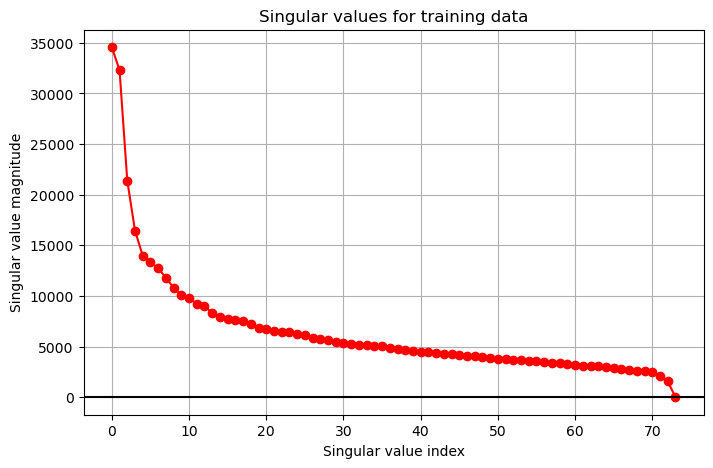

In [337]:
plt.plot(pca.model.singular_values_, "-o", color="red")
plt.xlabel("Singular value index")
plt.ylabel("Singular value magnitude")
plt.title("Singular values for training data")
plt.grid()
plt.axhline(0, color="black")
plt.show()

There is only one singular value that is equal to zero in this case. We can also plot ratio of the cumulative sum of these singular values, which gives the explained vario, over the total sum of all singular values to determine the ratio of the equation above:

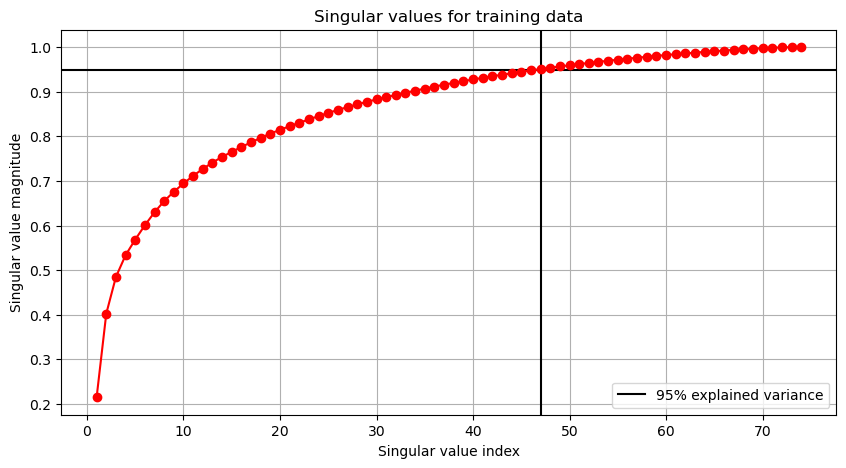

In [338]:
plt.figure(figsize = (10, 5))
# Get the cumulative sum of the explained variance
cumsum = np.cumsum(pca.model.explained_variance_ratio_)

# Plot the cumulative sum
plt.plot([i+1 for i in range(len(cumsum))], cumsum, "-o", color="red", zorder=100)

# For visualization, determine when we have 95% explained variance
for i, value in enumerate(cumsum):
    if value >= 0.95:
        break
plt.axhline(0.95, color="black")
plt.axvline(i + 1, color="black", label = "95% explained variance")
plt.xlabel("Singular value index")
plt.ylabel("Singular value magnitude")
plt.title("Singular values for training data")
plt.grid()
plt.legend(loc="lower right")
plt.show()

For the discussion below, we will initialize a default PCA feature extractor which uses 20 principal components. We will work in color, which might give worse results than using grayscale images since we have three times more "pixel variables", but working with color images allows for better visualizations. 

In [339]:
pca = PCAFeatureExtractor()
pca.fit(train_X)

### 1.2.1. Eigenface Plots

While fitting our PCA feature extractor to the training data, we also saved the __mean face__. Remember that PCA flattens the images into arrays of size $K^2$, and views the pixels as random variables. We can hence take the mean of each pixel over our training set, and end up with an array containing the mean of all pixels. By reshaping this mean array into an image of size $K\times K$, we can reconstruct this average as an image, and this average is called the mean face: it gives an average representation of a face, according to our training data.

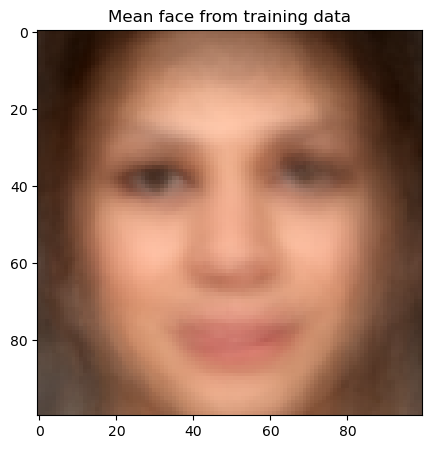

In [340]:
plt.imshow(pca.meanface, cmap="Greys_r")
plt.title("Mean face from training data")
plt.show()

By fitting the PCA feature extractor, we keep a certain number of "principal components" which are either eigenvectors of the covariance matrix or vectors corresponding to singular values, according to the decomposition used in the PCA. Similar to the mean vector, we can reshape these eigenvectors into an image of size $K\times K$ and visualize them. When the training data consists of faces, these eigenvectors are often referred to as __eigenfaces__, since (when visualized) they resemble faces. These faces (vectors) are used to project images of faces onto a lower-dimensional representation, and due to their order, they maximize the amount of information they retain of the original faces. Below, we plot some of these eigenfaces, in order of decreasing singular values (hence, most important to least important).

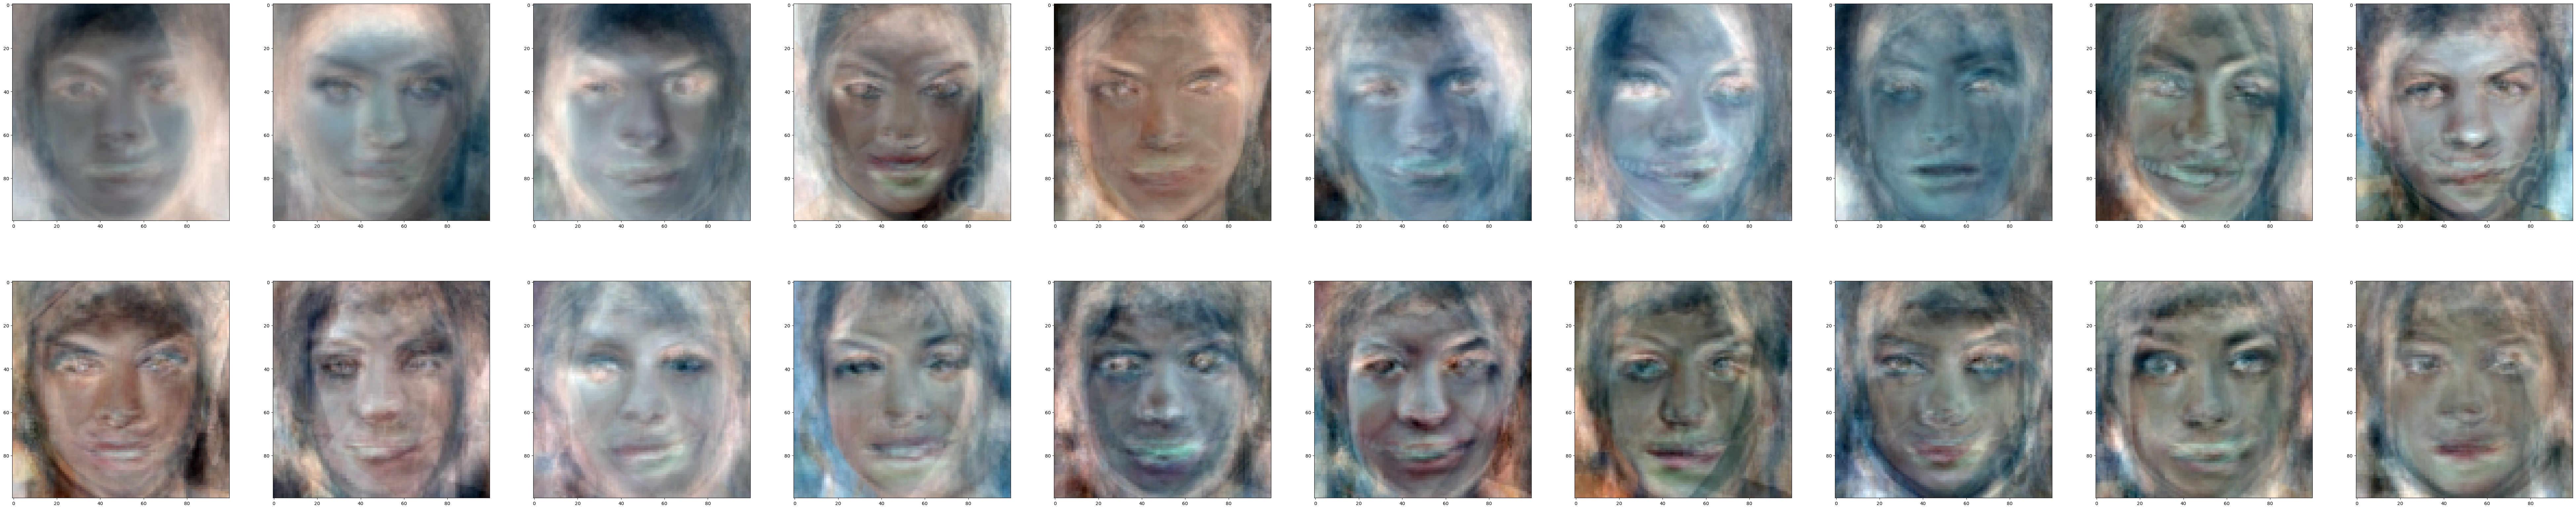

In [341]:
nb_eigenfaces_to_show = pca.n_components
nb_per_row = 10
plot_image_sequence(pca.eigenfaces[0:nb_eigenfaces_to_show], n=nb_eigenfaces_to_show, imgs_per_row=nb_per_row)

### 1.2.2. Feature Space Plots

Since the projection of a data point by PCA on a lower-dimensional representation is reversible, we can compare an original image with its "reconstruction". That is, we project an image on its lower-dimensional representation, and apply the reverse transformation to get back an image of the original size. This can essentially be seen as a compression or reconstruction, as the new image is created from less information. The number of principal components determines the quality of the reconstructed image. Below, we show an example of such a reconstruction using 20 principal components.

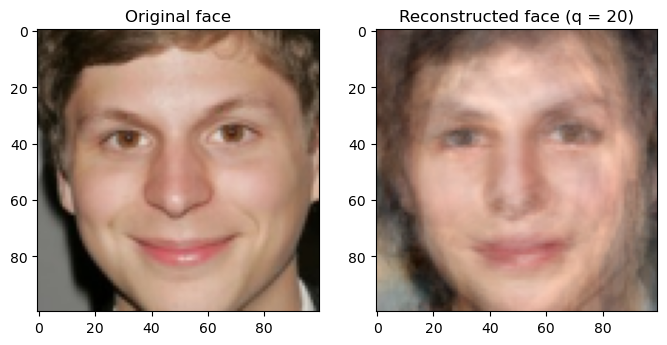

In [342]:
# Take an example face to reconstruct
fig, (ax0, ax1) = plt.subplots(1, 2)
example_face = train_X[2]
# If we don't use color, convert to grayscale
if not pca.use_color:
    example_face = np.mean(example_face, axis=2)

# Plot the original face
ax0.imshow(example_face.reshape(pca.shape), cmap="Greys_r")
ax0.set_title("Original face")
# Get reconstruction: first, project onto lower dimensonional repr
reduced = pca.transform([example_face])
# Then, reverse projection and reconstruct original
reconstructed = pca.inverse_transform([reduced])[0]
ax1.imshow(reconstructed, cmap="Greys_r")
ax1.set_title(f"Reconstructed face (q = {pca.n_components})")

plt.show()

As mentioned, the quality of this reconstruction depends on the amount of principal components to keep. Above, there are clear deviations between the original and reconstructed images. Below, we vary over the amount of principal components, below denoted by $q$, we use in the representation. This clearly shows that, while we clearly see only the mean face for low $q$, the reconstruction gradually uses more information of the face of interest, until the final images, with a high value of $q$, show hardly any difference with the original image. 

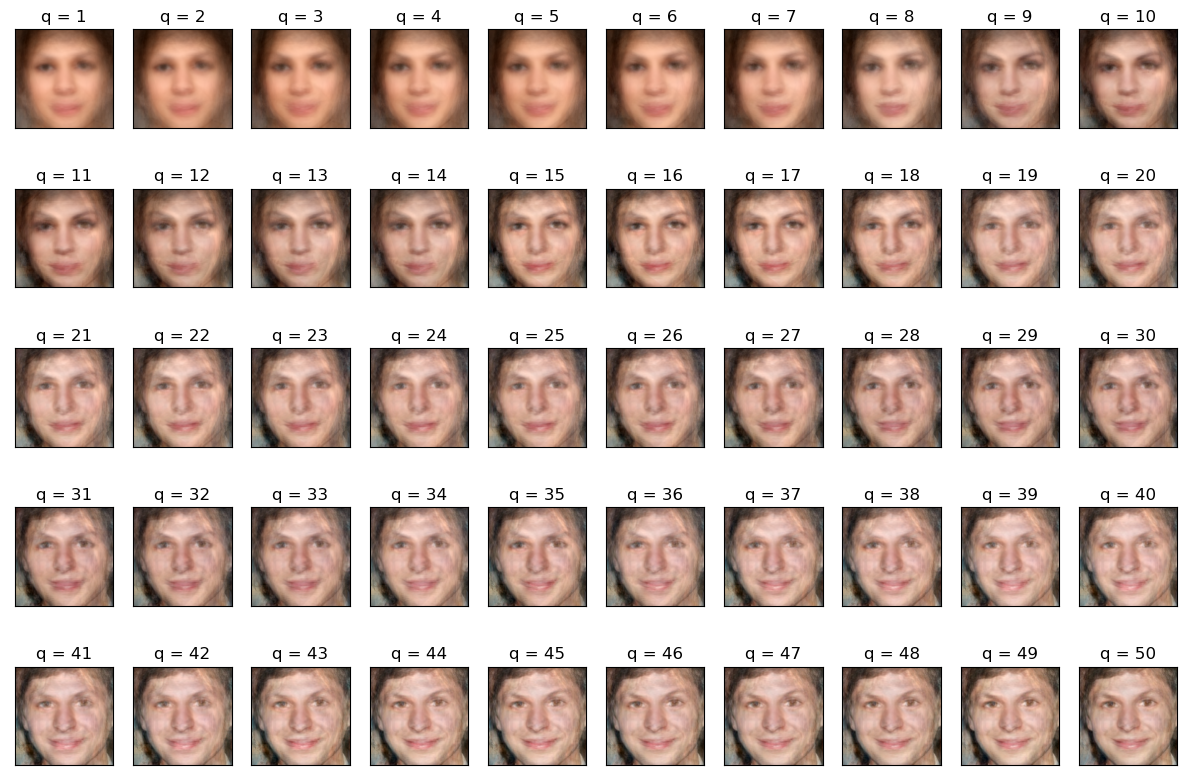

In [343]:
max_nb_components = 50
nb_per_row = 10

fig, axs = plt.subplots(max_nb_components//nb_per_row, nb_per_row, figsize = (15, 10))

for nb_of_components in range(max_nb_components):
    # Get the current axis
    ax = axs[nb_of_components // nb_per_row, nb_of_components % nb_per_row]
    # Set number of principal components and recompute the projection matrix
    pca.n_components = nb_of_components+1
    pca.fit(train_X)
    # Compute the reconstruction
    reconstructed = pca.inverse_transform(pca.transform([example_face]))[0]
    # Plot it
    ax.imshow(reconstructed, cmap="Greys_r")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"q = {nb_of_components+1}")
    
plt.show()

Of course, while we visually see that the difference between the original image and its reconstruction decreases, we want to have a method of quantifying this difference. One possible measure between the two images is the **root-mean-square deviation** (RMSD) between the two images, viewed as two arrays $\boldsymbol{x}$ and $\hat{\boldsymbol{x}}$ of size $K^2$. The RMSD measure is then defined as
\begin{equation*}
    RMSD(\boldsymbol{x}, \hat{\boldsymbol{x}}) = \sqrt{\frac{\sum_{i=1}^{K^2} (x_i - \hat{x}_i)}{K^2}}
\end{equation*}

In [344]:
def rmsd(x: np.array, x_hat: np.array):
    """
    Computes root mean square deviation between two Numpy arrays.
    """

    return np.sqrt(np.mean((x - x_hat)**2))

Now, we will again iterate over the number of principal components $q$ we keep in the PCA, and compute for each value of $q$ the average RMSD on the training set. This could give us insights into how much information is being retained by the PCA projection, and could *e.g.* inform us on which value of $q$ would be the most ideal to use in our classification pipeline.

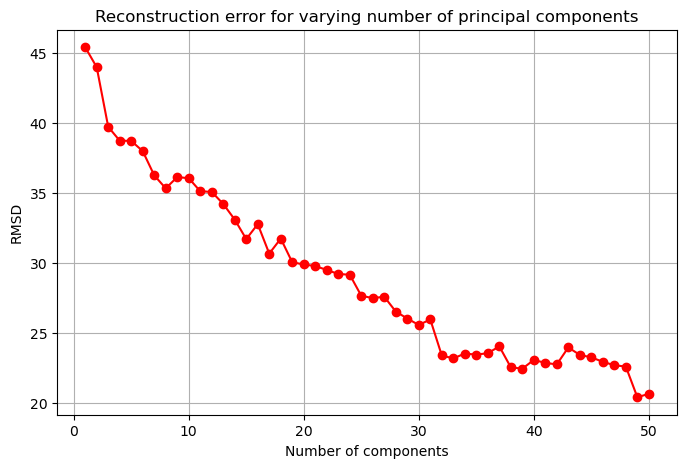

In [345]:
# Save the RMSD errors in a list
errors = []
max_nb_components = 50

# Check whether we train with grayscale or color images
if pca.use_color:
    original_data = train_X
else:
    # If we use grayscale, convert all the training images to grayscale as well
    original_data = np.array([np.mean(train_face, axis=2) for train_face in train_X])

for i in range(max_nb_components):
    # Set number of principal components and recompute the projection matrix
    pca.n_components = i+1
    pca.fit(train_X)
    # Compute the reconstruction
    reconstructed_faces = pca.inverse_transform(pca.transform(original_data))
    error = np.mean([rmsd(original_data, reconstructed_faces)])
    # Append to list, make sure to reshape
    errors.append(error)

plt.plot([i+1 for i in range(len(errors))], errors, '-o', color='red')
plt.ylabel("RMSD")
plt.xlabel("Number of components")
plt.title("Reconstruction error for varying number of principal components")
plt.grid()
plt.show()

We can use this information to choose the number of principal components to keep for the classifier later on. For instance, we can consider the "gain" in RMSD when we increase the number of principal components to keep. Below, we plot for each value of $q$ the difference between the RMSD value with $q$ components and $q+1$ components. Together with the previous plot, we see that we don't gain much additional information between $q=40$ and $q=50$, so it would make sense to try different values of $q$ in the classification pipeline later on up until a maximum value of $q = 40$, in order to guarantee a balance between informative features and a sparse, compact lower-dimensional representation of the faces. However, we will have to fine-tune the hyperparameter $q$ later on in our classification pipeline to find the ideal value for our classifiers. 

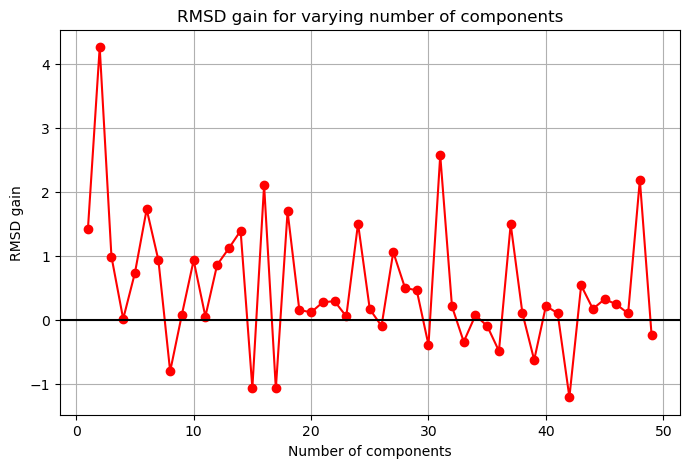

In [346]:
errors = np.array(errors)
next_errors = np.roll(errors, -1)
differences = errors - next_errors
plt.plot([i+1 for i in range(len(differences[:-1]))], differences[:-1], '-o', color='red')
plt.ylabel("RMSD gain")
plt.xlabel("Number of components")
plt.title("RMSD gain for varying number of components")
plt.axhline(0, color='black')
plt.grid()
plt.show()

A quantitative measure such as the RMSD is also a great way to compare our different face detectors and choose which preprocessed data is more suited for our use case here. For this, we repeat the above analysis for both the training data we obtained from the HAAR and the MTCNN data. We observe that the HAAR reconstruction loss is slightly below the reconstruction loss obtained with MTCNN.

In [349]:
## This cell takes around 3 minutes to evaluate
# Save the RMSD errors in a list
all_errors = [[], [], []]
max_nb_components = 50

# Iterate over our two training sets, make the reconstruction and compute errors
for j, train_data in enumerate([train_X_HAAR, train_X_MTCNN, train_X_DEEP]):

    # Check whether we train with grayscale or color images
    if pca.use_color:
        original_data = train_data
    else:
        # If we use grayscale, convert all the training images to grayscale as well
        original_data = np.array([np.mean(train_face, axis=2) for train_face in train_data])

    for i in range(max_nb_components):
        # Set number of principal components and recompute the projection matrix
        pca.n_components = i+1
        pca.fit(train_data)
        # Compute the reconstruction
        reconstructed_faces = pca.inverse_transform(pca.transform(original_data))
        error = np.mean([rmsd(original_data, reconstructed_faces)])
        # Append to list
        all_errors[j].append(error)



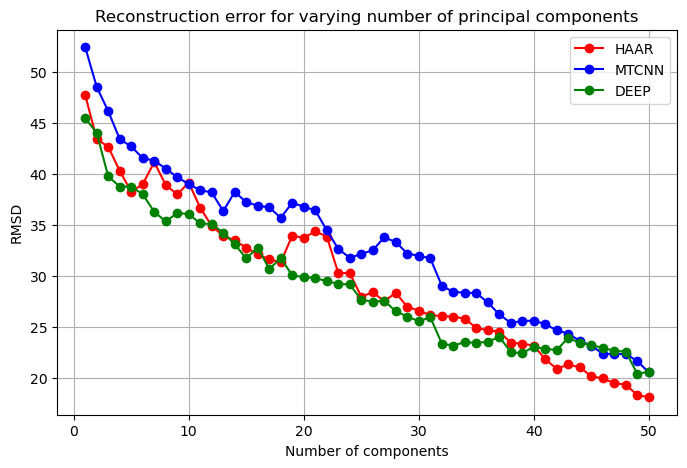

In [350]:
plt.plot([i+1 for i in range(len(all_errors[0]))], all_errors[0], '-o', color='red', label="HAAR")
plt.plot([i+1 for i in range(len(all_errors[1]))], all_errors[1], '-o', color='blue', label="MTCNN")
plt.plot([i+1 for i in range(len(all_errors[2]))], all_errors[2], '-o', color='green', label="DEEP")
plt.ylabel("RMSD")
plt.xlabel("Number of components")
plt.title("Reconstruction error for varying number of principal components")
plt.grid()
plt.legend()
plt.show()

#### Face-feature plots

Another great aspect about PCA is that we can create so-called **face-feature plots**, which can also be seen for instance in [this tutorial](https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/). In a face-feature plot, we plot the different faces of the training set at locations that are determined by their features obtained from the PCA projection. For visualization purposes, we therefore restrict ourselves to $q = 2$, such that there are only two eigenfaces of interest. Applying the PCA projection on each image then gives us a 2D representation of the faces, which determine the location in the grid where we plot each image. 

In [351]:
pca.n_components = 2
pca.fit(train_X)

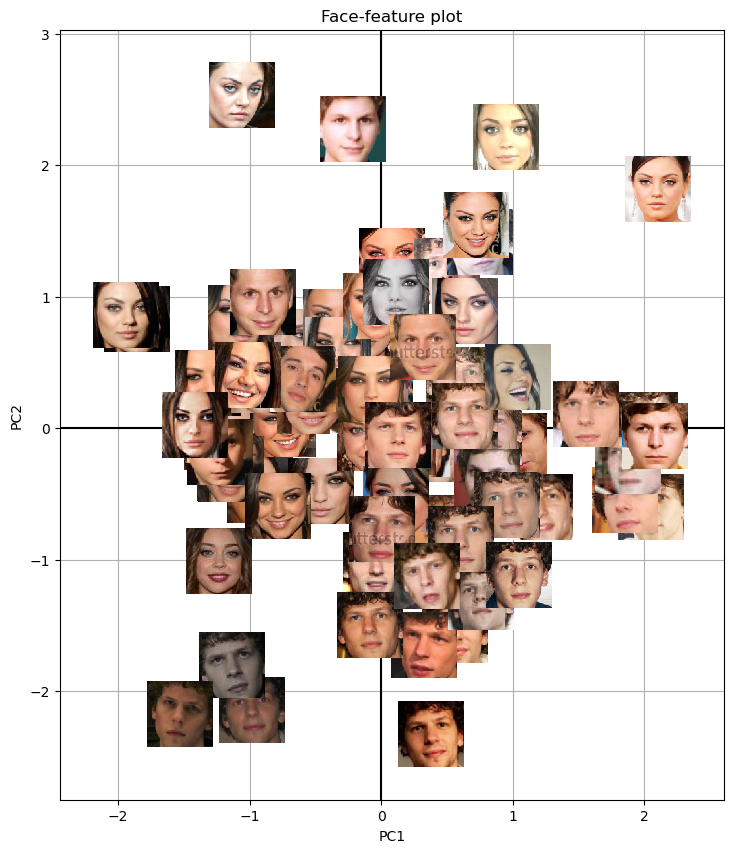

In [352]:
fig, ax = plt.subplots(figsize = (10,10))
# Parameters to play with to increase/decrease the boxes of the faces in the plot
delta_image = 0.25
delta_plot = 0.5
# Obtain the latent representations, i.e. after projecting with the PCA
latent_reps = np.array([pca.transform([image]).flatten() for image in original_data])

# Plot each image at their latent representation
for i in range(train_X.shape[0]):
    image = train_X[i]
    latent = latent_reps[i]
    ax.imshow(image, interpolation='nearest', extent=(latent[0]-delta_image, latent[0]+delta_image, latent[1]-delta_image, latent[1]+delta_image), zorder=100)

# Add annotations
plt.xlim(latent_reps[:, 0].min()-delta_plot, latent_reps[:, 0].max()+delta_plot)
plt.ylim(latent_reps[:, 1].min()-delta_plot, latent_reps[:, 1].max()+delta_plot)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Face-feature plot')
plt.axhline(0, color="black")
plt.axvline(0, color="black")
plt.grid()
plt.show()

Instead of plotting the faces, it is perhaps more informative to plot the class labels of the faces we extracted. This is done in the plot below, where black stands for class label 0, red for class label 1 and blue for class label 2.

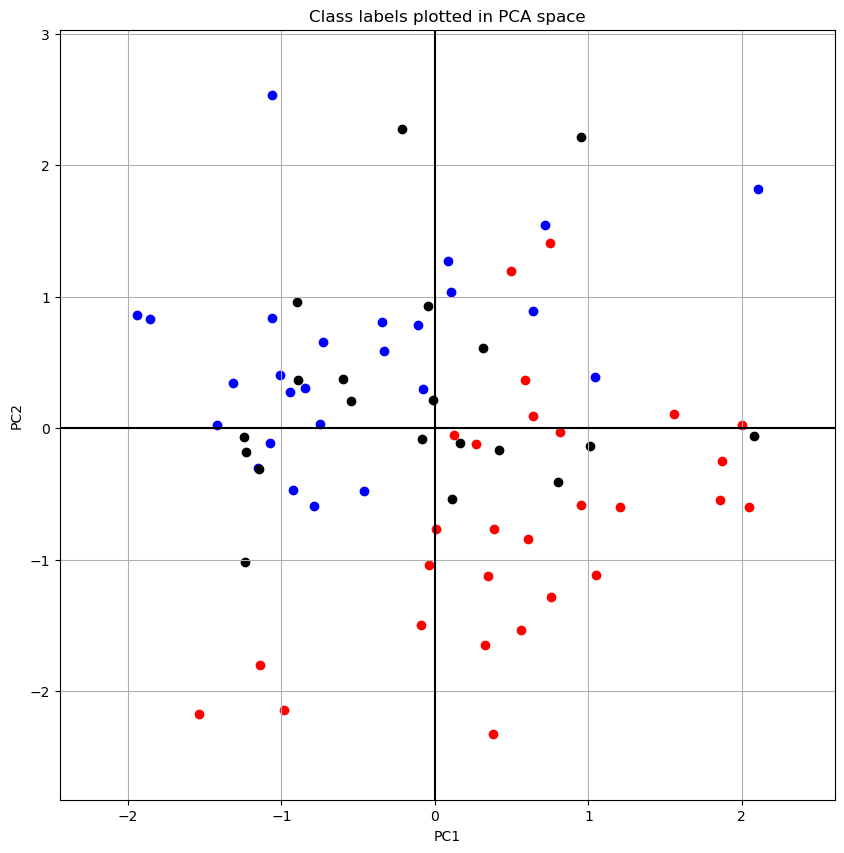

In [353]:
fig = plt.figure(figsize = (10,10))
# Parameters to play with to increase/decrease the plot window
delta_plot = 0.5
# Obtain the latent representations, i.e. after projecting with the PCA
latent_reps = np.array([pca.transform([image]).flatten() for image in original_data])

# Use colors instead of the faces
colors = ["black", "red", "blue"]

for i in range(original_data.shape[0]):
    image = original_data[i]
    latent = latent_reps[i]
    plt.scatter(latent[0], latent[1], color = colors[train_y[i]])

# Annotate plot
plt.xlim(latent_reps[:, 0].min()-delta_plot, latent_reps[:, 0].max()+delta_plot)
plt.ylim(latent_reps[:, 1].min()-delta_plot, latent_reps[:, 1].max()+delta_plot)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Class labels plotted in PCA space')
plt.axhline(0, color="black")
plt.axvline(0, color="black")
plt.grid()
plt.show()

Apart from some data points, we see that the red and blue classes are well separated. However, the lookalikes, denoted by the black dots, are spread throughout the PCA space. However, we have take into account that this is a PCA representation based on only 2 principal components, which is very low and hence we expect the separation between classes to be quite poor. By increasing the amount of principal components, we can make the PCA features more discriminative

### 1.2.3. Discussion

Attempt to choose an optimal number p of principal components such that the dimensionality
of the feature space is reduced but still informative (e.g. based on the average reconstruction
loss of your training images). 
Reflect on your choice of p and how this might have influenced the performance of the features that you learned. Did you need specifc pre-processing steps before computing these
feature descriptors on your images (which ones and why)? How many non-zero eigenvalues did you have, why is this? Did the visualisation show good discriminative and robustness properties?

*answer all of these, maybe in different paragraphs*

__NOTE__ these are more or less answered above, maybe add a final "overview" discussion of PCA? Still have to comment on "how many non-zero eigenvalus did you have and why?" -- not sure what to say here

# 2. Evaluation Metrics


# 3. Classifiers
## 3.0. Example: The random classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

In [44]:
class RandomClassificationModel:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""
    
    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """
        
        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self
        
    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset
            
        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size = X.shape[0], p=self.class_ratio)
    
    def __call__(self, X):
        return self.predict(X)
    

## 3.1. Baseline 1: My favorite classifier

For SVM, see [this tutorial](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html).

In [45]:
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import time

In [46]:
n_components = 50
pca = PCAFeatureExtractor(n_components = n_components)
pca.fit(train_X)

In [47]:
# Get the PCA representation of train and test data
if pca.use_color:
    original_data = train_X
else:
    # If we use grayscale, convert all the training images to grayscale as well
    original_data = np.array([np.mean(train_face, axis=2) for train_face in train_X])
train_X_pca = pca.transform(original_data)

In [48]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(
    train_X_pca, train_y, test_size=0.25, random_state=42
)

# Now search for best params for SVC

param_grid = {
    "C": loguniform(1e-1, 1e5),
    "gamma": loguniform(1e-7, 1e2),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=500
)
start = time.time()
clf = clf.fit(X_train, y_train)
end = time.time()
print("done in %0.3fs" % (end - start))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

done in 4.781s
Best estimator found by grid search:
SVC(C=79746.84826501754, class_weight='balanced', gamma=1.8663635276230452e-07)


              precision    recall  f1-score   support

           0       0.40      0.67      0.50         3
           1       0.78      0.70      0.74        10
           2       0.80      0.67      0.73         6

    accuracy                           0.68        19
   macro avg       0.66      0.68      0.65        19
weighted avg       0.73      0.68      0.70        19



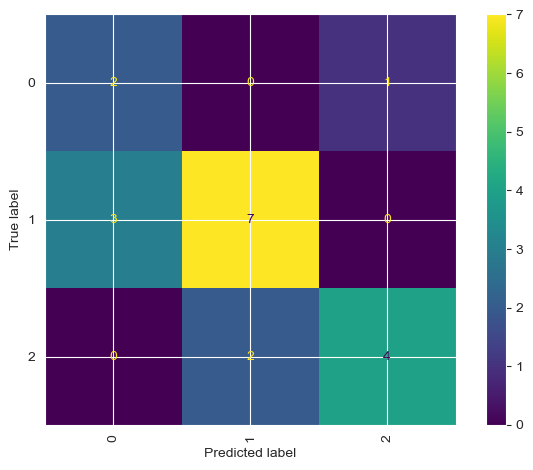

In [49]:
pred_y = clf.predict(X_test)

print(classification_report(y_test, pred_y))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test, y_test, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

In [50]:
class FavoriteClassificationModel:
    """TODO: this classifier is under construction."""

    def __init__(self):

        self.model = None

    
    def fit(self, X, y):
        # Now search for best params for SVC

        param_grid = {
            "C": loguniform(1e-1, 1e5),
            "gamma": loguniform(1e-7, 1e2),
        }
        clf = RandomizedSearchCV(
            SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=500
        )
        clf = clf.fit(X_train, y_train)
        print(clf.best_estimator_)

        # Save the best model
        self.model = clf.best_estimator_


    def predict(self, X):
        return self.model.predict(X)
    
    def __call__(self, X):
        return self.predict(X)

### 3.2 SIFT Classifier

In [51]:
class SIFTClassifier:

    def __init__(self, k):
        self.k = k
        self.hist = None
        self.clp = None
        self.kmeans = None

    # flatten descriptors to two dimensions
    def flatten(self, arr):
        all_descriptors = []
        for img_descriptors in arr:
            # get each feature from image
            for descriptor in img_descriptors:
                all_descriptors.append(descriptor)
        all_descriptors = np.stack(all_descriptors)
        return all_descriptors

    # fit datat with mini batch k means
    def fit(self, desc):
        flattened_desc = self.flatten(desc)
        kmeans = MiniBatchKMeans(n_clusters=self.k, batch_size=20).fit(flattened_desc)
        self.kmeans = kmeans

    # cluster data into histograms based on prediction
    def histogram(self, all_kp, all_desc):
        hist = []
        for i in range(len(all_desc)):
            hist_i = np.zeros(self.k)
            nkp = np.size(all_kp[i])

            for d in all_desc[i]:
                idx = self.kmeans.predict([d])
                hist_i[idx] +=1/nkp
            hist.append(hist_i)
        self.hist = hist
        return hist

    # train classifier
    def train(self, train_hist, train_y):
        param_grid = {
            "C": loguniform(1e-1, 1e5),
            "gamma": loguniform(1e-7, 1e2),
        }
        clf = RandomizedSearchCV(
            SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=500)
        start = time.time()
        clf = clf.fit(np.array(train_hist), train_y)
        end = time.time()
        print("done in %0.3fs" % (end - start))
        print("Best estimator found by grid search:")
        print(clf.best_estimator_)
        self.clf = clf
        return clf

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

classifier = SIFTClassifier(10)

# split training data
X_train, X_test, y_train, y_test = train_test_split(
    train_X_HAAR, train_y_HAAR, test_size=0.25, random_state=42
)

# get descriptors and keypoints of train data
train_des, train_kp = SIFTExtractor.detect_and_compute(X_train)
classifier.fit(train_des)
# cluster training points by their keypoints
train_hist = classifier.histogram(train_kp, train_des)
# train
clf = classifier.train(train_hist, y_train)

# get desscriptors and keypoints of test data
test_des, test_kp = SIFTExtractor.detect_and_compute(X_test)
# cluster test data by keypoints
test_hist = classifier.histogram(test_kp, test_des)
# predict
pred_y = classifier.clf.predict(test_hist)

print(classification_report(y_test, pred_y))

done in 7.809s
Best estimator found by grid search:
SVC(C=68.58280562901048, class_weight='balanced', gamma=0.00722071912265399)
              precision    recall  f1-score   support

           0       0.43      0.60      0.50         5
           1       0.33      0.67      0.44         3
           2       1.00      0.44      0.62         9

    accuracy                           0.53        17
   macro avg       0.59      0.57      0.52        17
weighted avg       0.71      0.53      0.55        17



## 3.1. Baseline 2: Transfer learning CNN

In [57]:
# Import keras VGG and fine tune layers
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from keras.models import Model
from keras.layers import Dense, Flatten, Input
from keras.optimizers import Adam
import keras.callbacks

class VGGFaceFeatureExtractorAndClassifier:
    """We use pre-trained weights and the architecture of a neural network trained on face images. 
       We append an additional layer to the network to classify the 4 classes of our dataset serving as feature extractor + classifier integrated
       in one model. We could also use the embeddings from the top layer of the network to calculate face similaries but we preffered to fine-tune the network
       and therefore perform transfer-learning based on our training dataset."""

    def __init__(self):
        # Load
        # vgg = VGG16(include_top=False, input_shape=FACE_SIZE + (3,))
        
        # Load the same pretrained model we are using in previous steps of the pipeline
        # so we do not have to re-download the weights
        vgg = DeepFace.VGGFace.loadModel()

        # vgg.trainable = False

        # for layer in vgg.layers:
        #     if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
        #         layer.trainable = True

        # Beware: a higher number of neurons would overfit on the training dataset
        classifier = Dense(32, activation='relu')(vgg.layers[-1].output)
        
        # Modify top layers to classify 4 classes
        output_prob = Dense(4, activation='softmax')(classifier)

        # Save modified model with the new layers
        self.model = Model(inputs=vgg.inputs, outputs=output_prob)

    def fit(self, X, y):
        # Use the same preprocessing as the pretrained model
        X_train = vgg16_preprocess_input(X)

        # Compile model and set a small learning rate (we resume where the pretrained model stopped and we dont want to overshoot on the weights)
        self.model.compile(run_eagerly=True, optimizer=Adam(
            learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

        callbacks = [
            keras.callbacks.ModelCheckpoint(
                "best_model", save_best_only=True, monitor='val_sparse_categorical_accuracy', save_format='tf',
            ),
        ]

        # Fit model, should converge from 6 to 8 epochs. It will stop automatically when it reaches 100% accuracy on the training set.
        self.model.fit(X_train, y, epochs=8,
                       batch_size=32, validation_split=0.2, callbacks=callbacks)

    def predict(self, X):
        return self.model.predict(vgg16_preprocess_input(X))

    def __call__(self, X):
        return self.predict(X)


In [58]:
vgg_fe_cls = VGGFaceFeatureExtractorAndClassifier()
vgg_fe_cls.model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_65_input (In  [(None, 224, 224, 3)]    0         
 putLayer)                                                       
                                                                 
 zero_padding2d_65 (ZeroPadd  (None, 226, 226, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d_80 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_66 (ZeroPadd  (None, 226, 226, 64)     0         
 ing2D)                                                          
                                                                 
 conv2d_81 (Conv2D)          (None, 224, 224, 64)      36928     
                                                          

In [59]:
vgg_fe_cls.fit(train_X, train_y)

Epoch 1/8
2/2 [==============================] - ETA: 0s - loss: 3.3108 - sparse_categorical_accuracy: 0.3051 

2/2 [==============================] - 100s 59s/step - loss: 3.3108 - sparse_categorical_accuracy: 0.3051 - val_loss: 0.9414 - val_sparse_categorical_accuracy: 0.7333
Epoch 2/8
2/2 [==============================] - ETA: 0s - loss: 0.8110 - sparse_categorical_accuracy: 0.7627 

2/2 [==============================] - 89s 51s/step - loss: 0.8110 - sparse_categorical_accuracy: 0.7627 - val_loss: 0.3348 - val_sparse_categorical_accuracy: 0.8667
Epoch 3/8
2/2 [==============================] - ETA: 0s - loss: 0.1910 - sparse_categorical_accuracy: 0.9661 

2/2 [==============================] - 87s 49s/step - loss: 0.1910 - sparse_categorical_accuracy: 0.9661 - val_loss: 0.1695 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/8
2/2 [==============================] - 72s 34s/step - loss: 0.0858 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0997 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/8
2/2 [==============================] - 69s 33s/step - loss: 0.0518 - sparse_categorical_accuracy: 0.9831 - val_loss: 0.0609 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/8
2/2 [==============================] - 69s 33s/step - loss: 0.0141 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0380 - val_sparse_categorical_accuracy: 1.0000
Epoch 7/8
2/2 [==============================] - 70s 34s/step - loss: 0.0237 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0219 - val_sparse_categorical_accuracy: 1.0000
Epoch 8/8
2/2 [==============================] - 76s 34s/step - loss: 0.0094 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0

In [76]:
test_y_probs = vgg_fe_cls.predict(test_X_HAAR) # TODO: REPLACE HAAR FOR DEEPFACE... just like it is done for the training set...!!

# disable numpy scientific notation
np.set_printoptions(suppress=True)

test_y_probs

57/57 [==============================] - 294s 5s/step


array([[0.00048528, 0.999503  , 0.00000539, 0.00000631],
       [0.93906665, 0.00415153, 0.05469019, 0.00209164],
       [0.9919471 , 0.00735229, 0.00008639, 0.00061421],
       ...,
       [0.00104401, 0.99886024, 0.00005491, 0.00004087],
       [0.9998944 , 0.00003608, 0.00005708, 0.00001246],
       [0.99769115, 0.00118885, 0.00012845, 0.00099153]], dtype=float32)

In [81]:
test_y_star = np.argmax(test_y_probs, axis=1)
test_y_star

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

__NOTE__ this is very basic and brute force code as test

In [ ]:
feature_extractor = PCAFeatureExtractor(n_components=n_components, use_color=False)
feature_extractor.fit(train_X)
classifier = FavoriteClassificationModel()

# train the model on the features
classifier.fit(feature_extractor(original_data), train_y)

# model/final pipeline
model = lambda X: classifier(feature_extractor(X))

In [ ]:
# evaluate performance of the model on the training set
train_y_star = model(original_data)

"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
    accuracy_score(train_y, train_y_star))

In [ ]:
# predict the labels for the test set 
test_y_star = model(test_X)

# 5. Publishing best results

In [ ]:
submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_star

submission

In [ ]:
submission.to_csv('submission.csv')

# 6. Discussion
...

In summary we contributed the following: 
* 
